In [1]:
%load_ext watermark
%watermark -a 'cs224' -u -d -v -p numpy,xarray,scipy,pandas,sklearn,matplotlib,seaborn,pymc3

cs224 
last updated: 2020-05-28 

CPython 3.6.10
IPython 7.13.0

numpy 1.18.1
xarray 0.15.0
scipy 1.4.1
pandas 1.0.2
sklearn 0.22.1
matplotlib 3.1.3
seaborn 0.10.0
pymc3 3.8


In [2]:
%matplotlib inline
import numpy as np, scipy, scipy.stats as stats, scipy.special, scipy.misc, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, xarray as xr
import matplotlib as mpl

import pymc3 as pm

import theano as thno
import theano.tensor as T

import sklearn, sklearn.linear_model

import datetime, time, math
from dateutil import relativedelta

from collections import OrderedDict

SEED = 42
np.random.seed(SEED)

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.set_printoptions(edgeitems=10)
np.set_printoptions(linewidth=1000)
np.set_printoptions(suppress=True)
np.core.arrayprint._line_width = 180

sns.set()
# sns.set_style("whitegrid")

In [3]:
from IPython.display import display, HTML

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        if type(df) == np.ndarray:
            df = pd.DataFrame(df)
        html_str+=df.to_html()
    html_str = html_str.replace('table','table style="display:inline"')
    # print(html_str)
    display_html(html_str,raw=True)

CSS = """
.output {
    flex-direction: row;
}
"""

def display_graphs_side_by_side(*args):
    html_str='<table><tr>'
    for g in args:
        html_str += '<td>'
        html_str += g._repr_svg_()
        html_str += '</td>'
    html_str += '</tr></table>'
    display_html(html_str,raw=True)
    

display(HTML("<style>.container { width:70% !important; }</style>"))

In [4]:
%load_ext autoreload
%autoreload 1
%aimport covid19

* [Corona-Hub von www.npgeo.de](https://npgeo-corona-npgeo-de.hub.arcgis.com/)
    * [RKI COVID19](https://npgeo-corona-npgeo-de.hub.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0)
    * [CSV](https://opendata.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0.csv)
    * [Robert Koch-Institut: COVID-19-Dashboard](https://npgeo-corona-npgeo-de.hub.arcgis.com/app/478220a4c454480e823b17327b2bf1d4)
* [Priesemann-Group/covid19_inference_forecast](https://github.com/Priesemann-Group/covid19_inference_forecast/commit/4d34d342cd8e58c18b5107ce38c537d4e83bc561)
    * [data_retrieval.py](https://github.com/Priesemann-Group/covid19_inference_forecast/blob/master/covid19_inference/data_retrieval.py)

* [data source description](https://www.arcgis.com/home/item.html?id=f10774f1c63e40168479a1feb6c7ca74)

* [DRP Austria Covid-19 Hub](https://covid-19-drp-austria.hub.arcgis.com/)
    * [Dashboard](https://experience.arcgis.com/experience/fb603473e1f74f0bbae48155ff238565)
    * [Daten](https://covid-19-drp-austria.hub.arcgis.com/search?categories=covid-19)
        * [COVID19 VERLAUF BUNDESLAND](https://covid-19-drp-austria.hub.arcgis.com/datasets/covid19-verlauf-bundesland?orderBy=genesene&orderByAsc=false)
    * [data.gv.at](https://www.data.gv.at/covid-19/)

In [5]:
df = covid19.get_rki_df()
cbr_germany = covid19.CasesByRegion('Germany', df=df)
cbr_germany.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-05-23,178165,162697,8259,258,0,31
2020-05-24,178353,162697,8280,188,0,21
2020-05-25,178609,162697,8308,256,0,28
2020-05-26,179014,162696,8369,405,-1,61
2020-05-27,179216,162696,8429,202,0,60


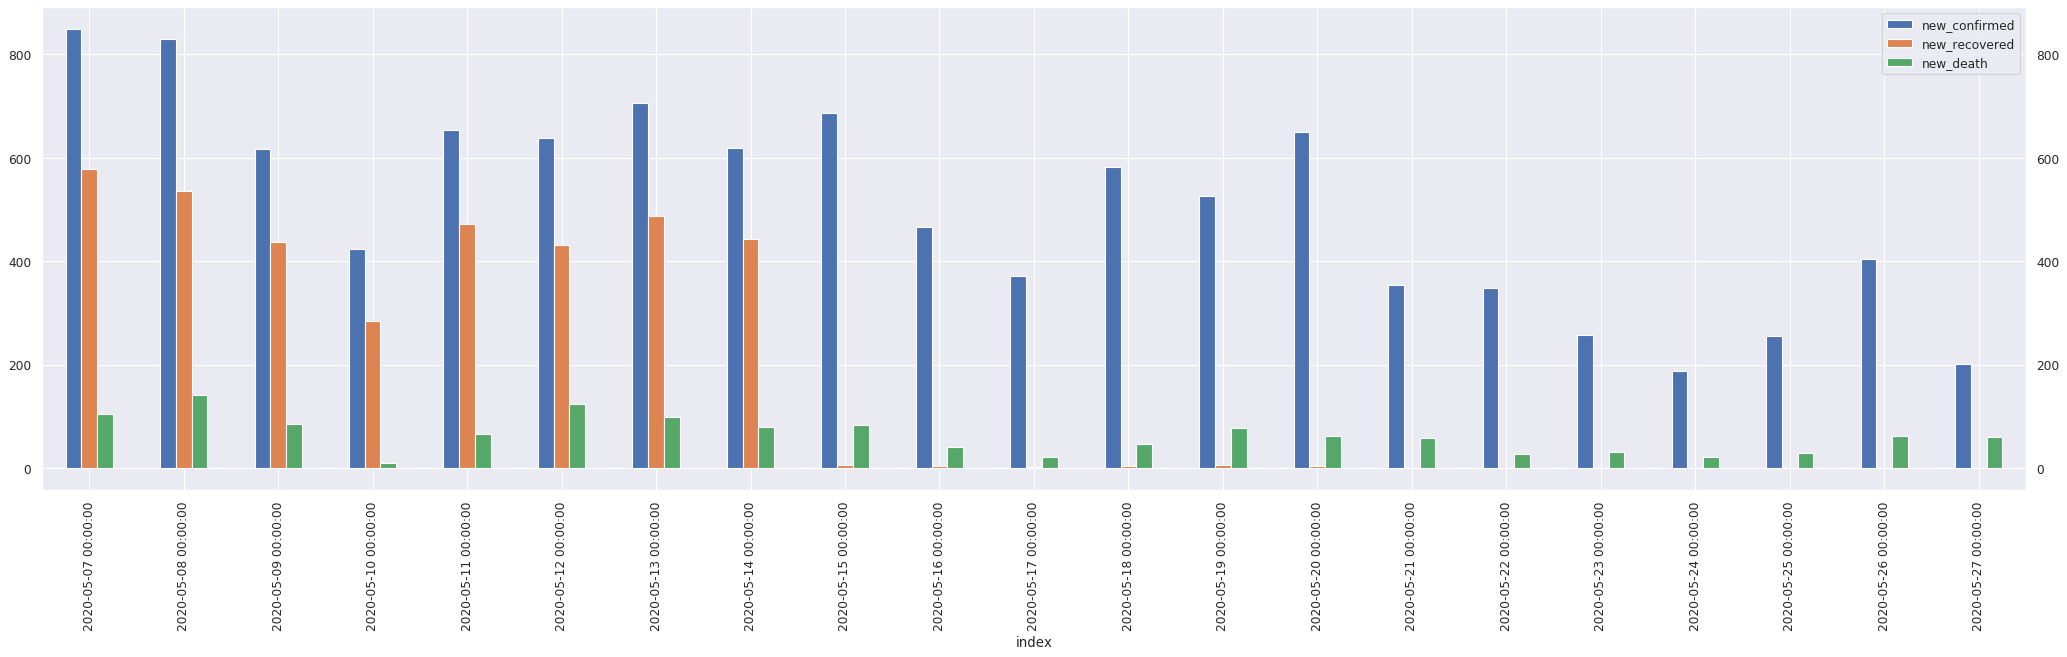

In [6]:
cbr_germany.plot_daily_stats()

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None
 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning:Covariance of the parameters could not be estimated


sigmoid+asymmetric: seor: 395.7015157188168, max asymptotic: 180989.83884186583; growth-rate: 0.001, date:2020-06-10 00:00:00, projected value: 88.40638189988495


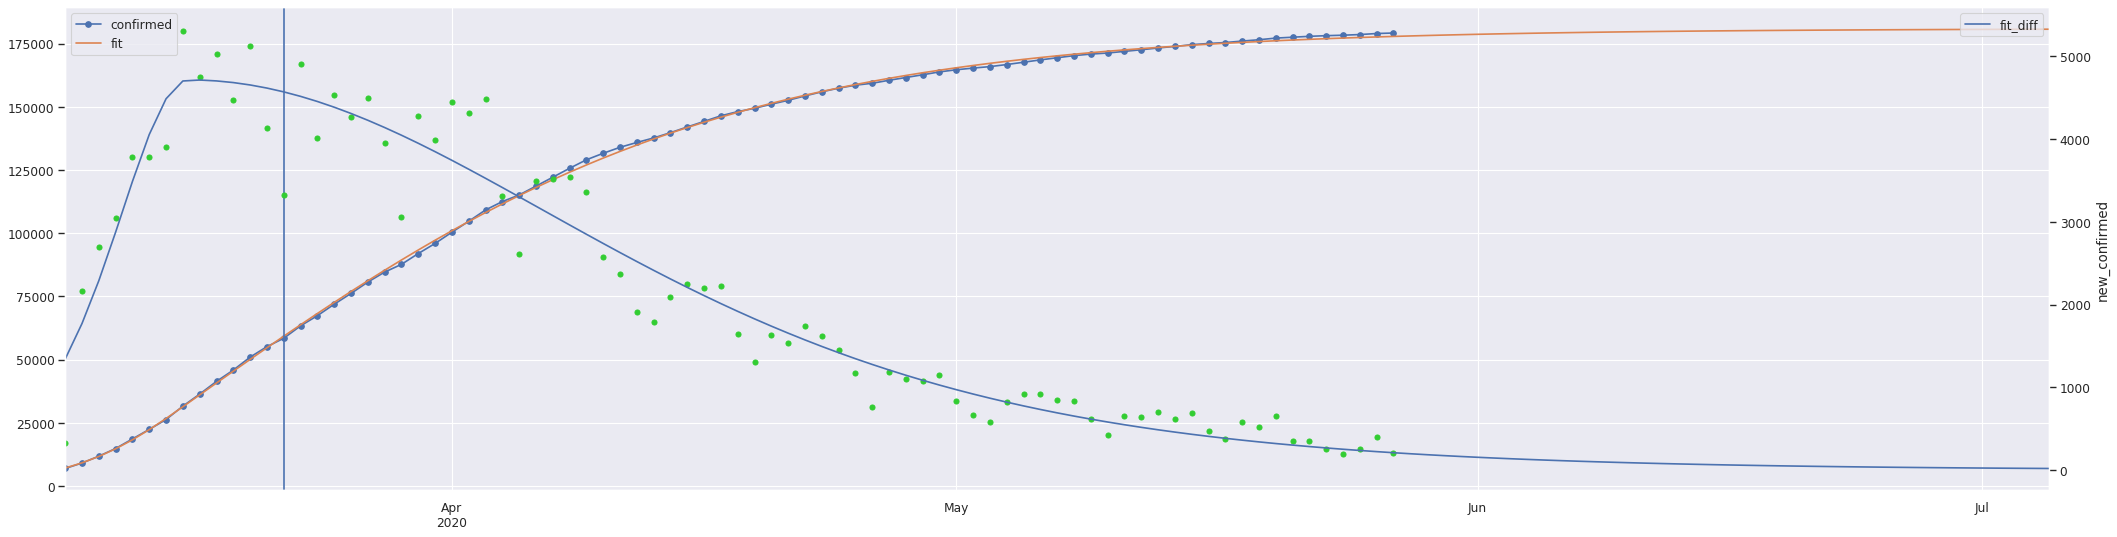

In [7]:
cbr_germany.fit(first_date=pd.to_datetime('2020-03-09'))
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_germany.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 22))

In [8]:
# country_name, first_date, init_add, restriction_start_date = 'Germany', pd.to_datetime('2020-03-09'), 0, datetime.datetime(2020, 3, 22)
# ldf, lpopt, lpcov, lsqdiff, lgrowthRate, idx, label = covid19.prepare_country_prediction(country_name, in_df=cbr_germany.df, first_date=first_date, init_add=init_add)
# if len(lpopt) == 4:
#     steady_state_rate = lpopt[1] * lpopt[3]
# else:
#     steady_state_rate = 0.0
# print(label, ldf.index[-1], lpopt, lgrowthRate, steady_state_rate)
# fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
# ax = plt.subplot(1,1,1)
# ldf[['confirmed', label + '_fit']].iloc[1:,:].plot(ax=ax, marker=mpl.path.Path.unit_circle(), markersize=5);
# ax.axvline(restriction_start_date);

# ax2 = ax.twinx()
# ldf[[label + '_fit_diff']].iloc[1:,:].plot(ax=ax2, color=['steelblue']);
# lbl = 'confirmed' + '_diff'
# ldf[[lbl]].iloc[1:,:].reset_index().plot.scatter(ax=ax2, x = 'index', y = lbl, c='limegreen')


# l = len(ax.get_yticks())
# a1 = ax.get_yticks()[0]
# e1 = ax.get_yticks()[-1]
# a2 = ax2.get_yticks()[0]
# e2 = ax2.get_yticks()[-1]
# ax.set_yticks(np.linspace(a1, e1, l));
# ax2.set_yticks(np.linspace(a2, e2, l));

In [9]:
cbr_germany.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,4714.618274


In [10]:
cbr_germany.calculate_R_estimates()
cbr_germany.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


,fit_R,gp_R,kf_R,ll_R,mean_R
index,,,,,
2020-05-25,0.589,0.482,0.289,0.409,0.493


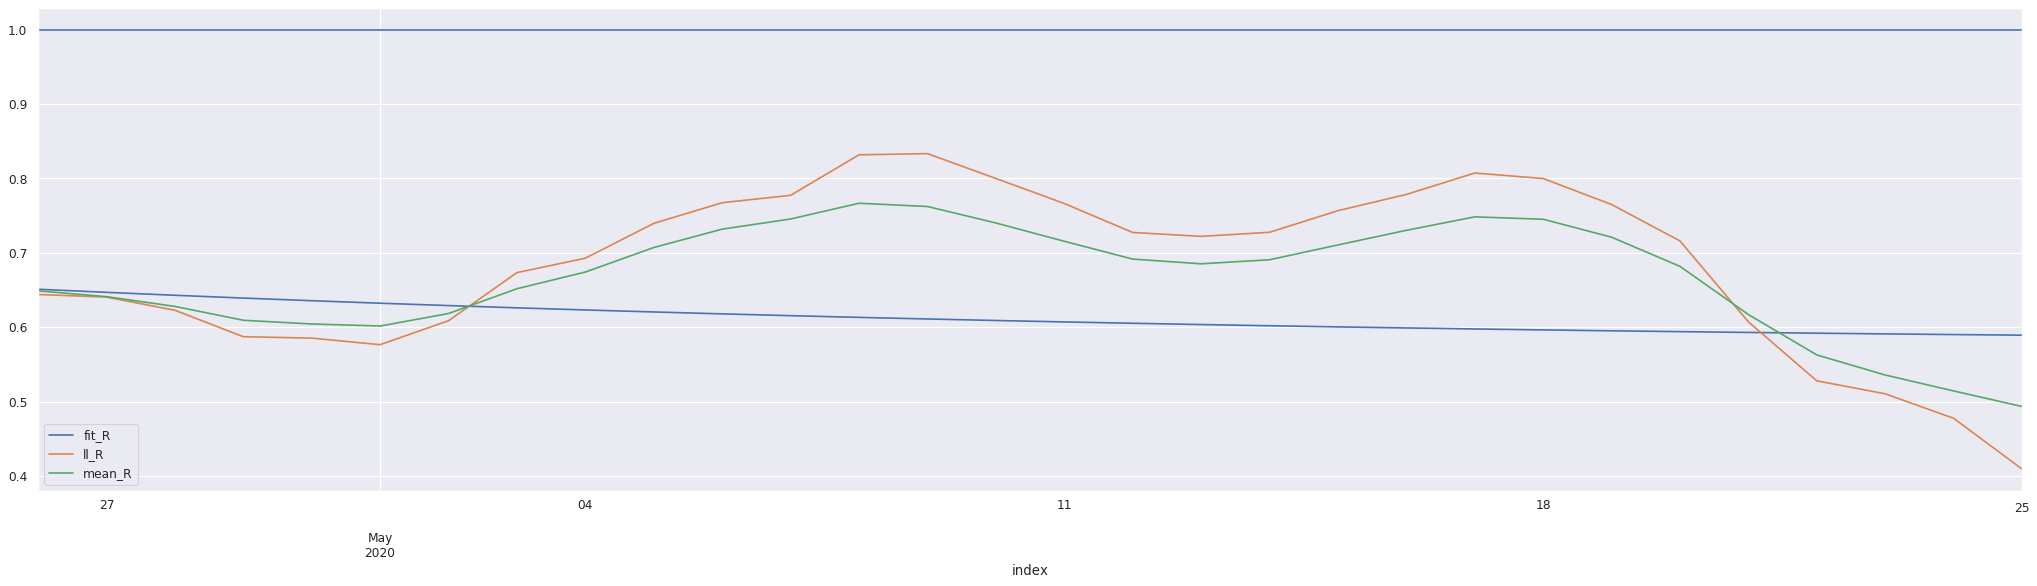

In [11]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_germany.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [12]:
# --------------------------------------------------------------------------------------------------------------------------------



# --------------------------------------------------------------------------------------------------------------------------------

In [13]:
df = covid19.get_rki_df(state='Bayern')
cbr_bavaria = covid19.CasesByRegion('Bavaria', df=df)
cbr_bavaria.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-05-23,46399,42369,2432,65,0,0
2020-05-24,46475,42369,2432,76,0,0
2020-05-25,46523,42369,2433,48,0,1
2020-05-26,46630,42368,2434,107,-1,1
2020-05-27,46697,42368,2434,67,0,0


In [14]:
einwohner_deutschland = 83019213.0
einwohner_bayern      = 13076721.0
prozent_bayern        = einwohner_bayern / einwohner_deutschland

bavaria_new_confirmed_threshold = (100.0 * prozent_bayern) // 1 + 1
bavaria_new_confirmed_threshold

16.0

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None
 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning:Covariance of the parameters could not be estimated


sigmoid+asymmetric: seor: 114.57186497288147, max asymptotic: 46546.4402391039; growth-rate: 0.001, date:2020-06-07 00:00:00, projected value: 14.277594536351147


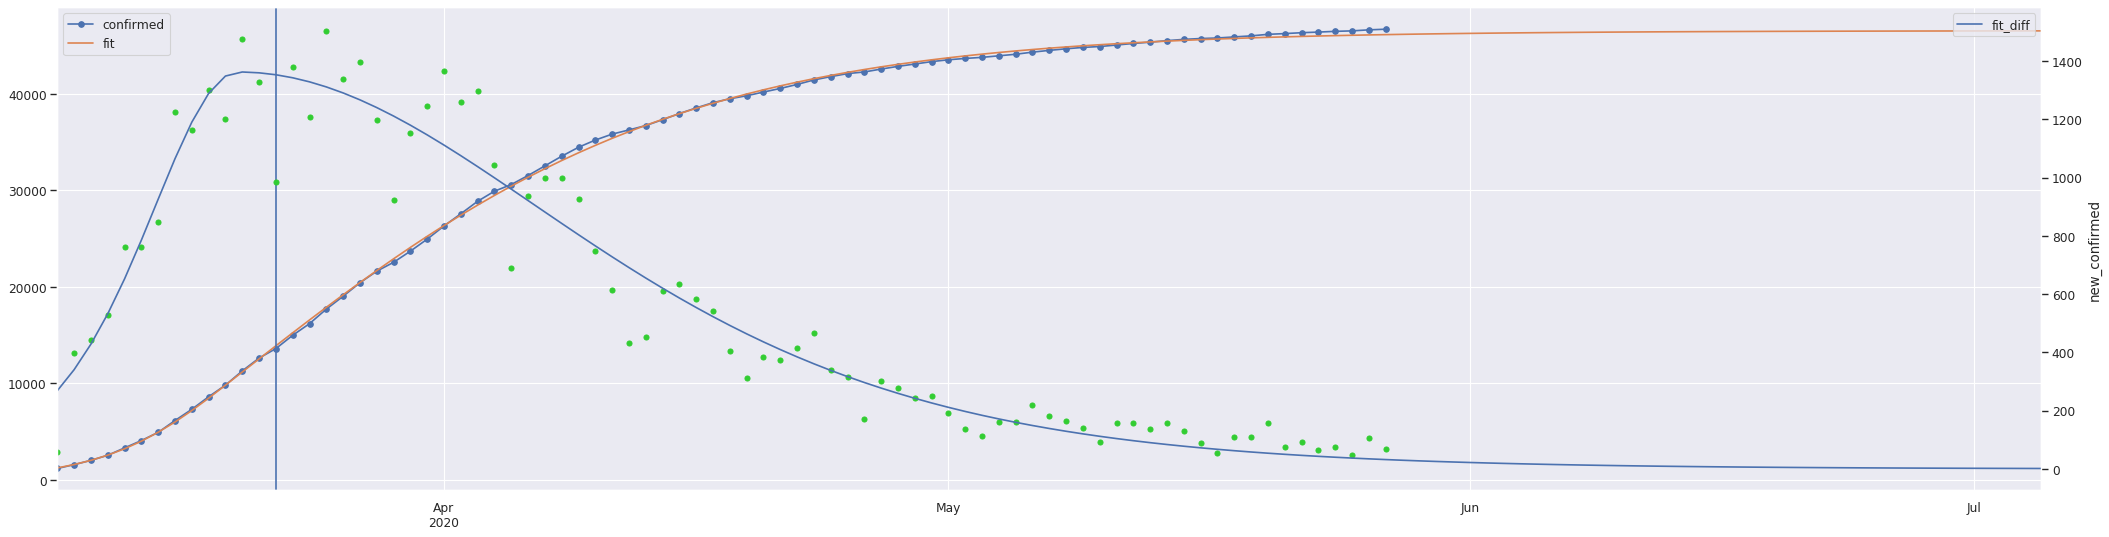

In [15]:
cbr_bavaria.fit(first_date=pd.to_datetime('2020-03-09'), new_confirmed_threshold=bavaria_new_confirmed_threshold)
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_bavaria.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 22))

In [16]:
cbr_bavaria.calculate_R_estimates()
cbr_bavaria.R().round(3)

,fit_R,gp_R,kf_R,ll_R,mean_R
index,,,,,
2020-05-25,0.504,0.818,0.605,0.71,0.677


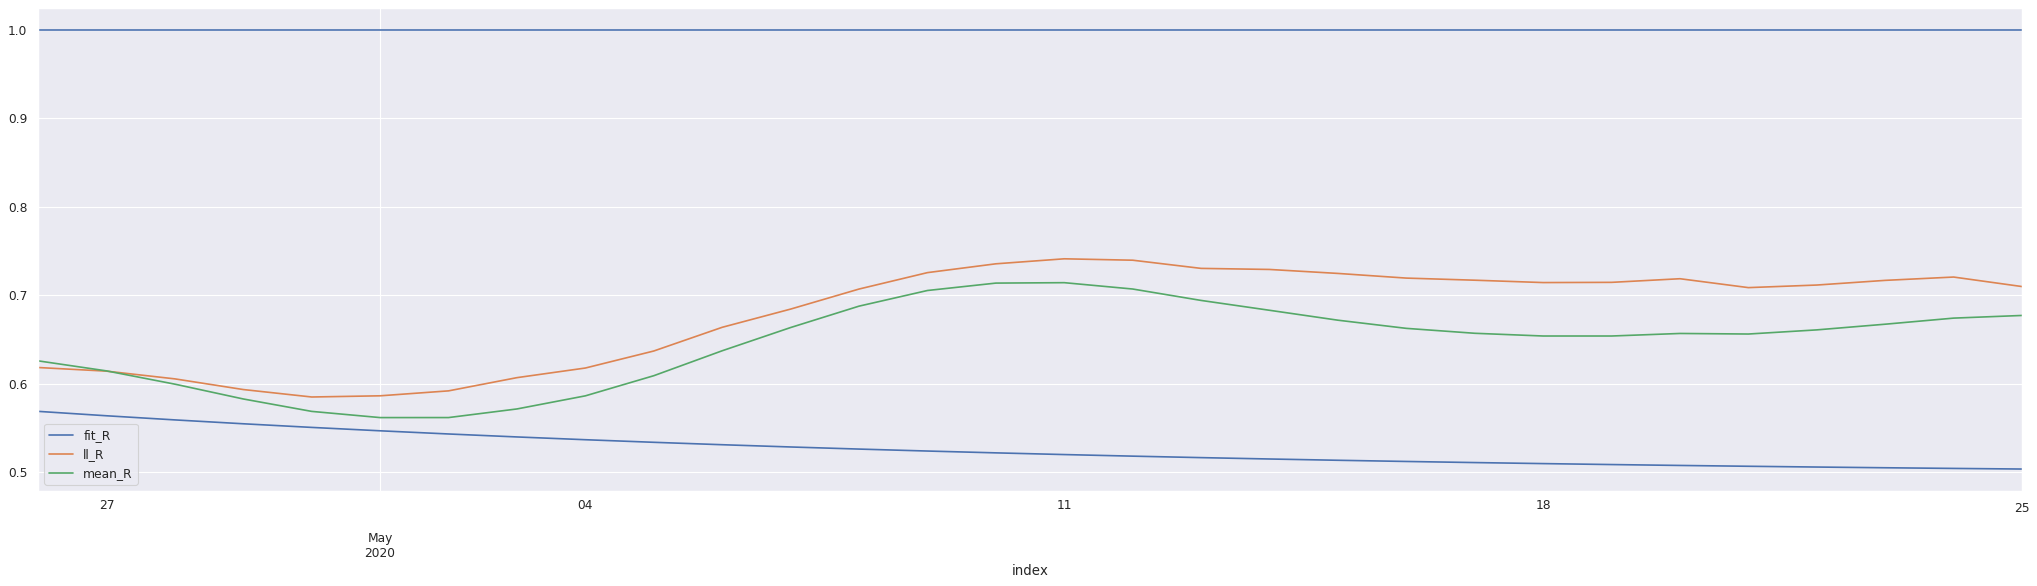

In [17]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_bavaria.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [18]:
df = covid19.get_rki_df(state='Nordrhein-Westfalen')
cbr_nrw = covid19.CasesByRegion('NRW', df=df)
cbr_nrw.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-05-23,37372,34118,1580,55,0,0
2020-05-24,37422,34118,1581,50,0,1
2020-05-25,37530,34118,1581,108,0,0
2020-05-26,37640,34118,1581,110,0,0
2020-05-27,37689,34118,1581,49,0,0


In [19]:
einwohner_nrw      = 17932651.0
prozent_nrw        = einwohner_nrw / einwohner_deutschland

nrw_new_confirmed_threshold = (100.0 * prozent_nrw) // 1 + 1
nrw_new_confirmed_threshold

22.0

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None


sigmoid+asymmetric+linear: seor: 93.25575868279597; growth-rate: 0.003, date:2020-07-05 00:00:00, projected value: 56.276969390396246


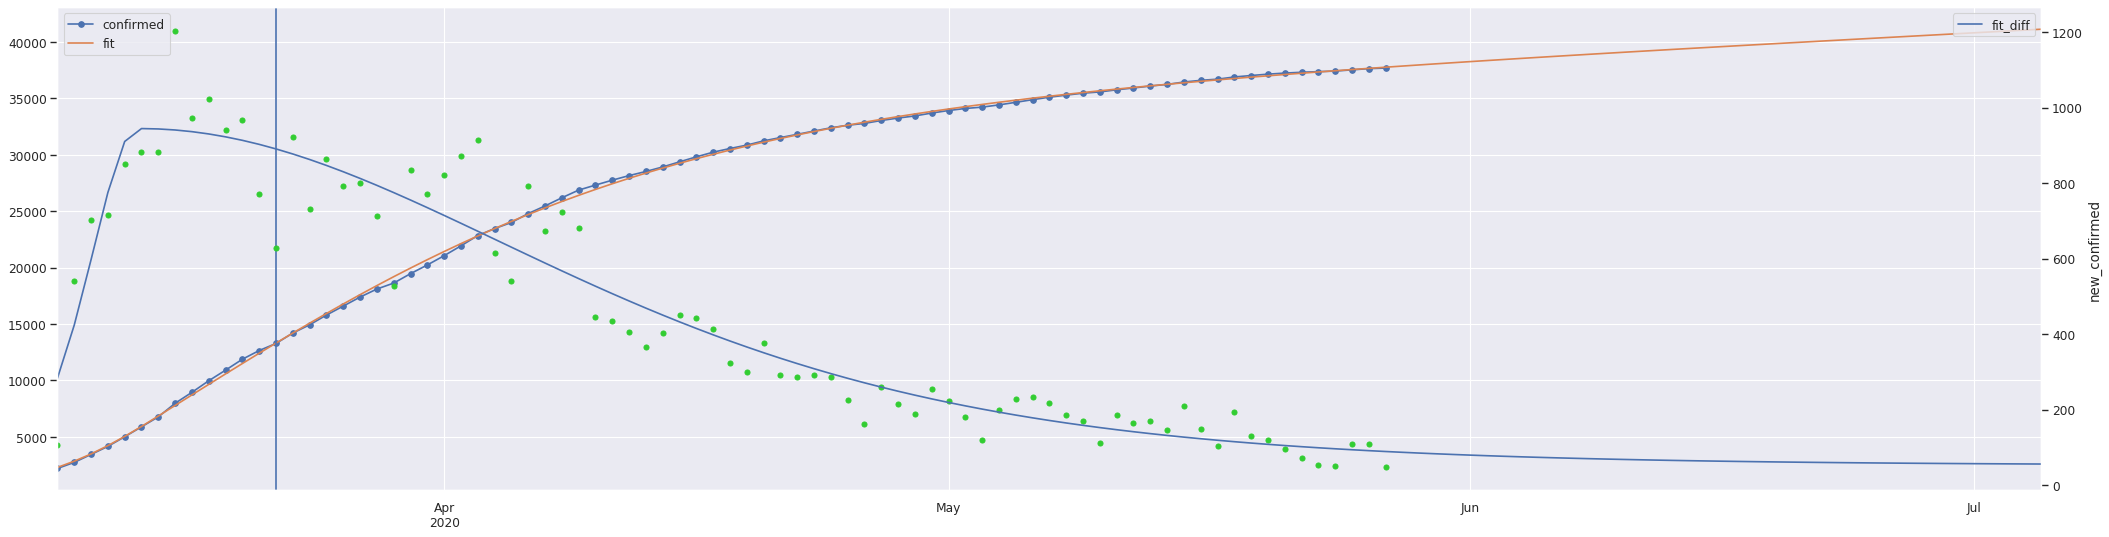

In [20]:
cbr_nrw.fit(first_date=pd.to_datetime('2020-03-09'), new_confirmed_threshold=nrw_new_confirmed_threshold)
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_nrw.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 22))

In [21]:
cbr_nrw.calculate_R_estimates()
cbr_nrw.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


,fit_R,gp_R,kf_R,ll_R,mean_R
index,,,,,
2020-05-25,0.798,0.388,0.211,0.301,0.495


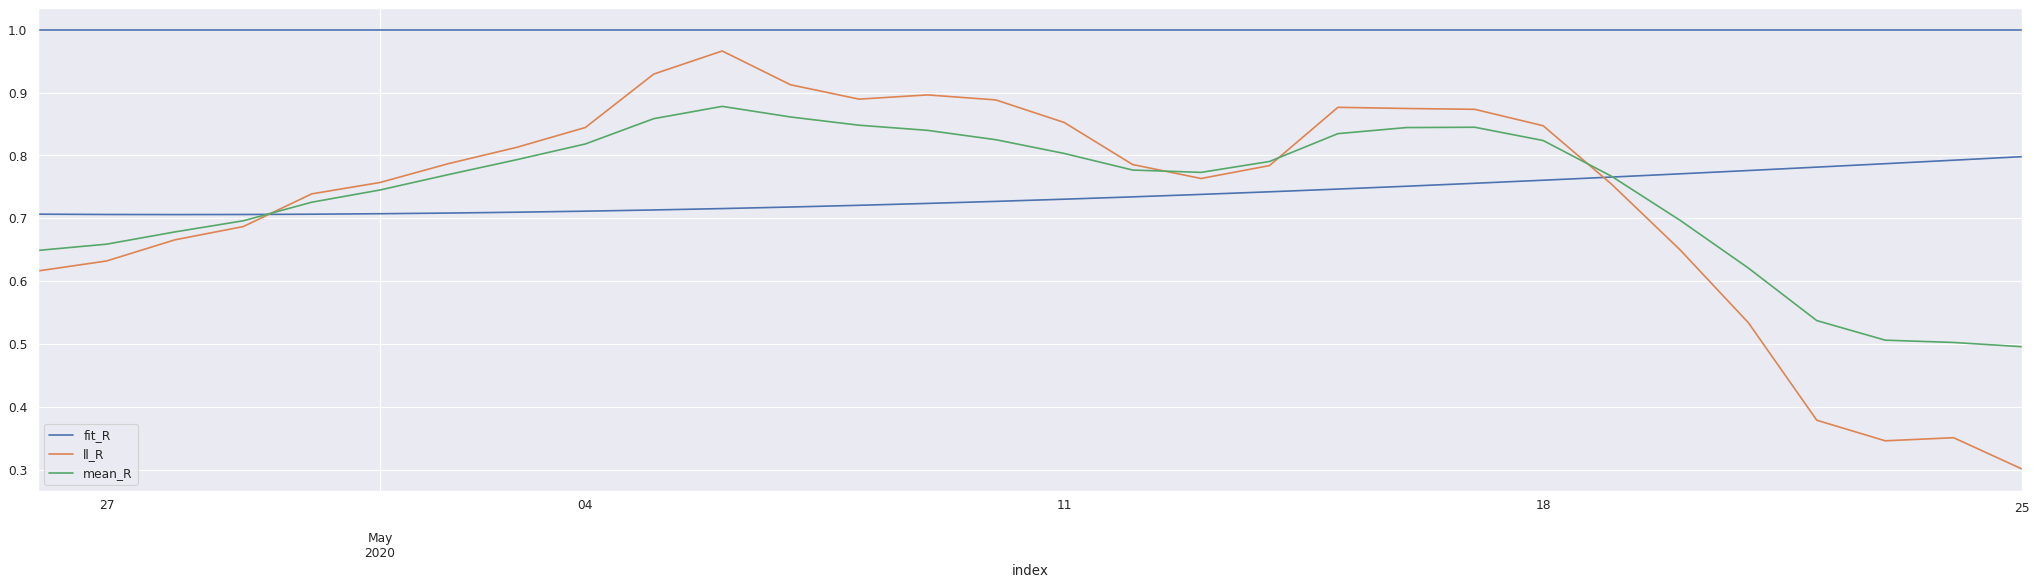

In [22]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_nrw.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [23]:
covid19.rki_data_df.Bundesland.unique()

array(['Schleswig-Holstein', 'Hamburg', 'Niedersachsen', 'Bremen', 'Nordrhein-Westfalen', 'Hessen', 'Rheinland-Pfalz', 'Baden-Württemberg', 'Bayern', 'Saarland', 'Berlin', 'Brandenburg', 'Mecklenburg-Vorpommern', 'Sachsen', 'Sachsen-Anhalt', 'Thüringen'], dtype=object)

In [24]:
df = covid19.get_rki_df(state='Baden-W')
cbr_bw = covid19.CasesByRegion('BW', df=df)
cbr_bw.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-05-23,33610,30829,1714,41,0,1
2020-05-24,33622,30829,1714,12,0,0
2020-05-25,33643,30829,1714,21,0,0
2020-05-26,33674,30829,1714,31,0,0
2020-05-27,33687,30829,1714,13,0,0


In [25]:
einwohner_bw      = 11069533.0
prozent_bw        = einwohner_bw / einwohner_deutschland

bw_new_confirmed_threshold = (100.0 * prozent_bw) // 1 + 1
bw_new_confirmed_threshold

14.0

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None
 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning:Covariance of the parameters could not be estimated


sigmoid+asymmetric: seor: 78.05907905473507, max asymptotic: 34150.37721610205; growth-rate: 0.001, date:2020-06-11 00:00:00, projected value: 12.8901298046586


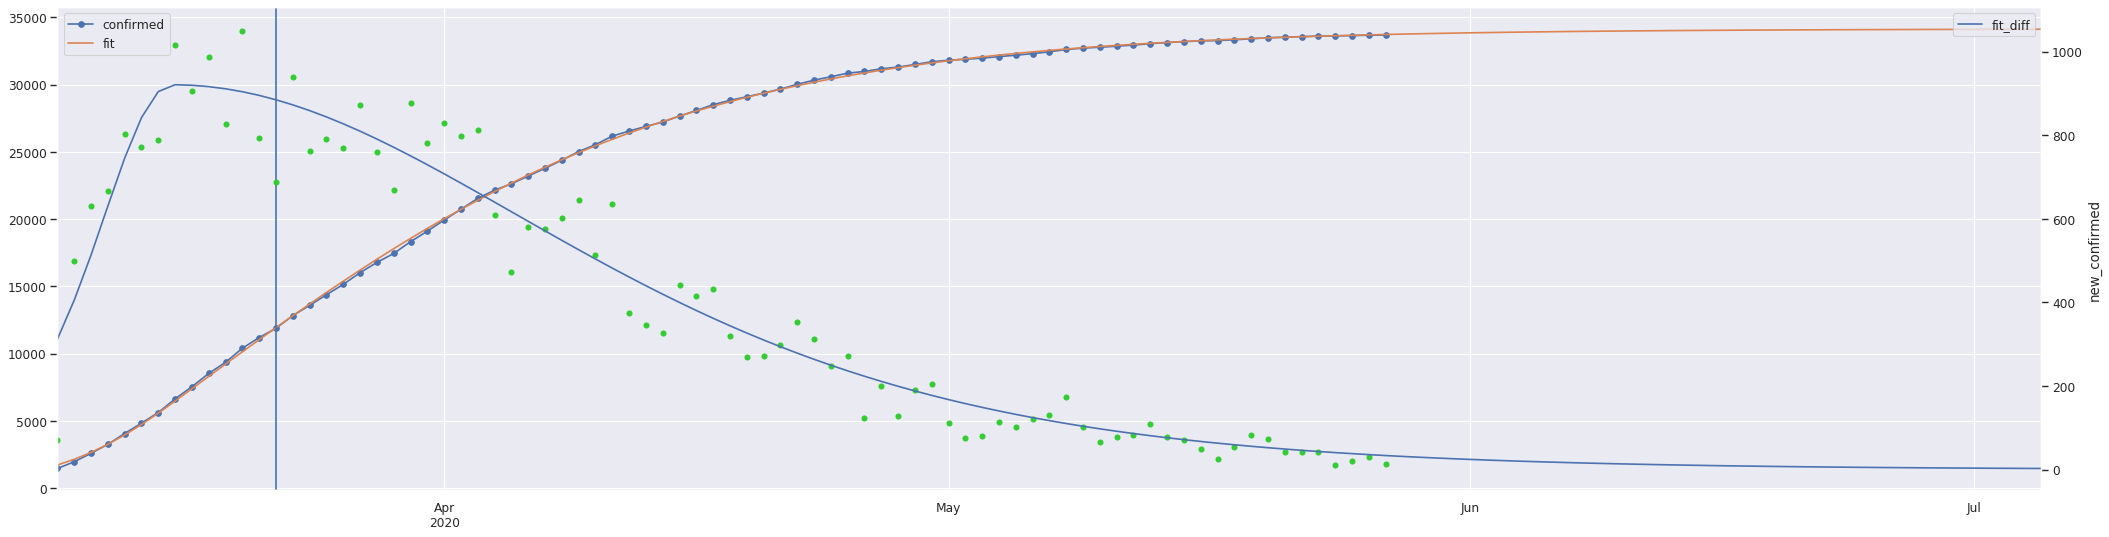

In [26]:
cbr_bw.fit(first_date=pd.to_datetime('2020-03-09'), new_confirmed_threshold=bw_new_confirmed_threshold)
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_bw.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 22))

In [27]:
cbr_bw.calculate_R_estimates()
cbr_bw.R().round(3)

,fit_R,gp_R,kf_R,ll_R,mean_R
index,,,,,
2020-05-25,0.572,0.643,0.428,0.537,0.584


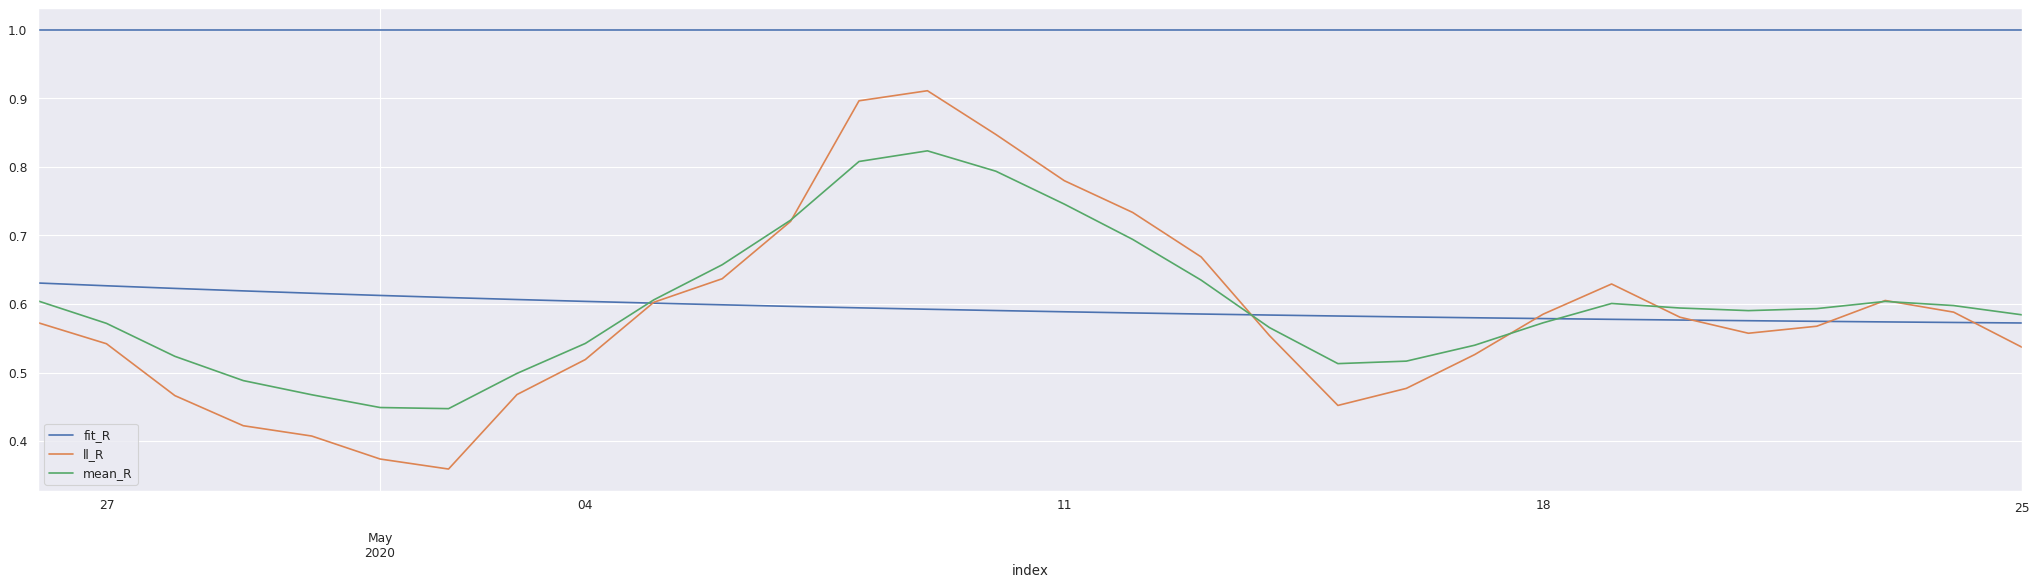

In [28]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_bw.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [29]:
df = covid19.get_rki_df(county='LK Traunstein')
cbr_traunstein = covid19.CasesByRegion('LK Traunstein', df=df)
cbr_traunstein.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-05-23,1292,1165,87,2,0,0
2020-05-24,1292,1165,87,0,0,0
2020-05-25,1294,1165,87,2,0,0
2020-05-26,1295,1165,87,1,0,0
2020-05-27,1297,1165,87,2,0,0


In [30]:
tage_inzidenz = 10

In [31]:
# https://www.destatis.de/DE/Themen/Laender-Regionen/Regionales/Gemeindeverzeichnis/Administrativ/04-kreise.html
einwohner_lk_traunstein = 177089
einwohner_sk_regensburg = 152610
einwohner_lk_regensburg = 193572

In [32]:
tage_inzidenz_lk_traunstein = cbr_traunstein.df['new_confirmed'][-tage_inzidenz:].sum() 
round(tage_inzidenz_lk_traunstein,1), round(tage_inzidenz_lk_traunstein / einwohner_lk_traunstein / tage_inzidenz  * 100000,1), round(tage_inzidenz_lk_traunstein / einwohner_lk_traunstein / tage_inzidenz  * 100000 * 7,1)

(22, 1.2, 8.7)

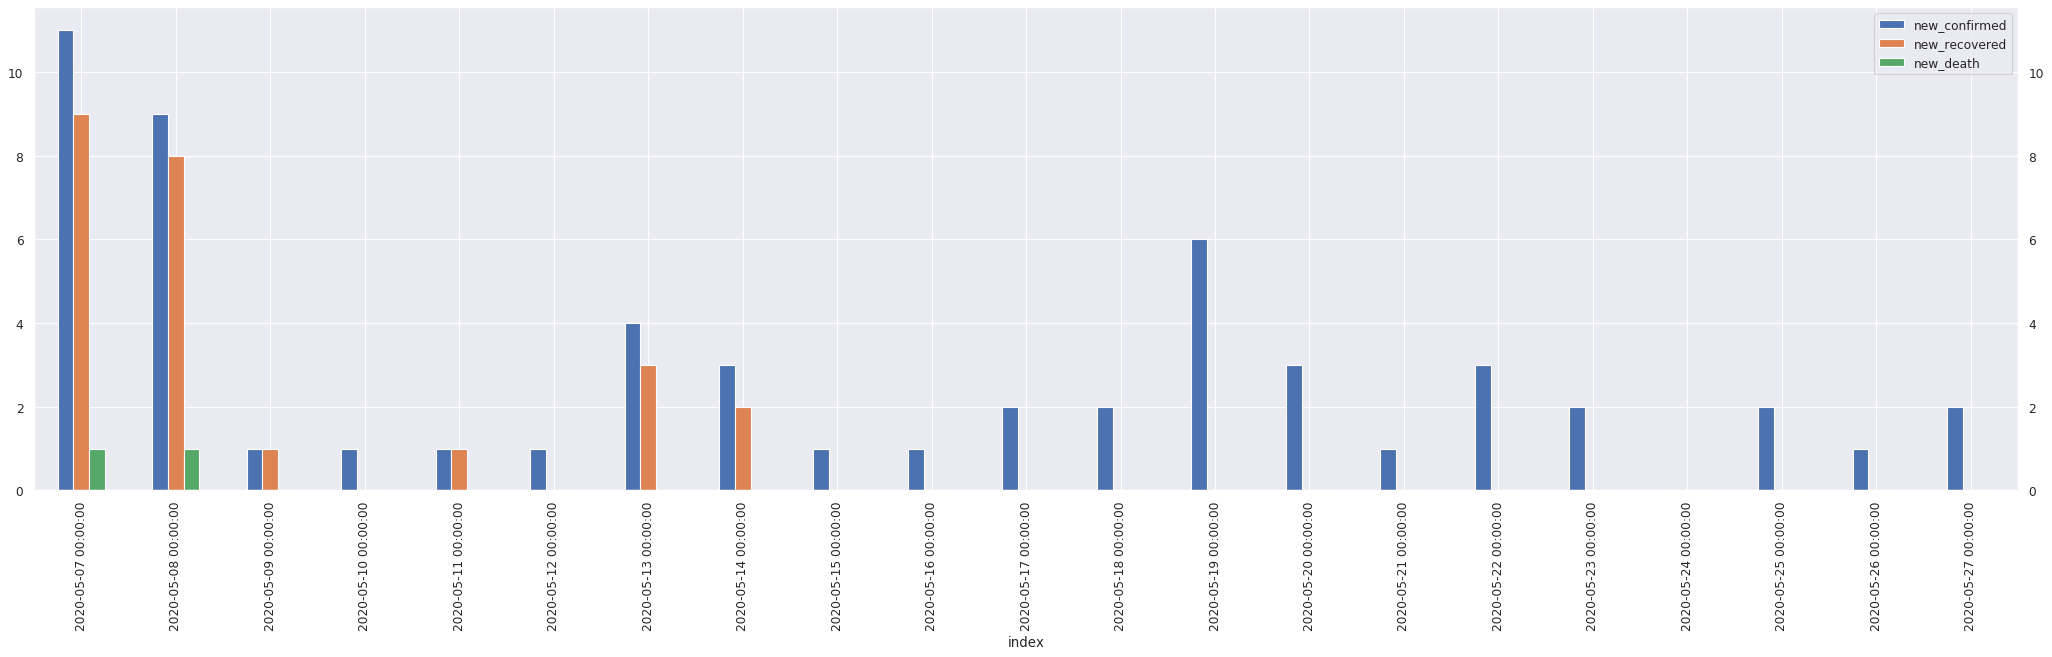

In [33]:
cbr_traunstein.plot_daily_stats()

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None
 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning:Covariance of the parameters could not be estimated


sigmoid+asymmetric: seor: 6.810215216517223, max asymptotic: 1360.454973969811; growth-rate: 0.002, date:2020-07-05 00:00:00, projected value: 0.29601441436391723


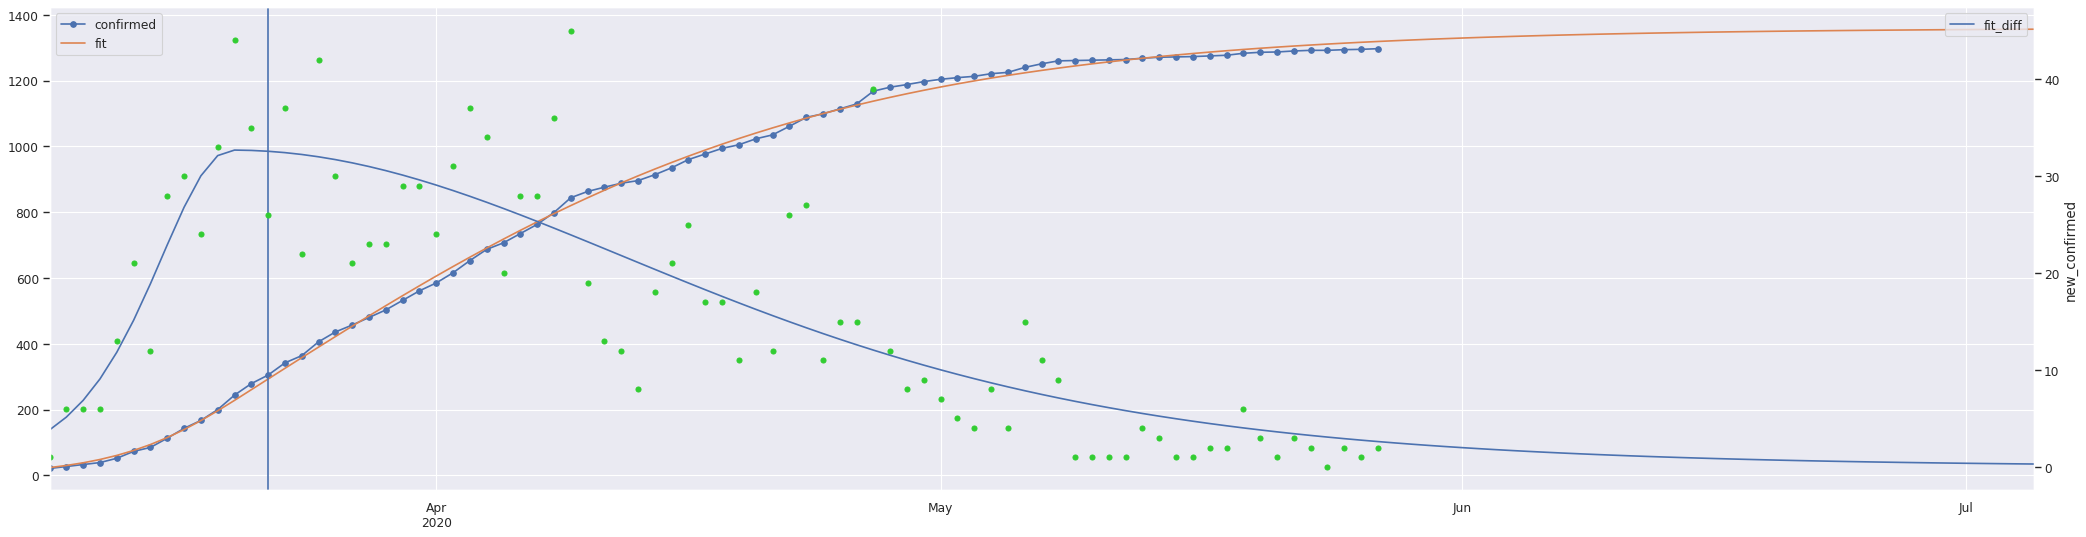

In [34]:
cbr_traunstein.fit(first_date=pd.to_datetime('2020-03-09'))
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_traunstein.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 22))

In [35]:
cbr_traunstein.calculate_R_estimates()
cbr_traunstein.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


,fit_R,gp_R,kf_R,ll_R,mean_R
index,,,,,
2020-05-25,0.635,0.852,0.844,0.731,0.739


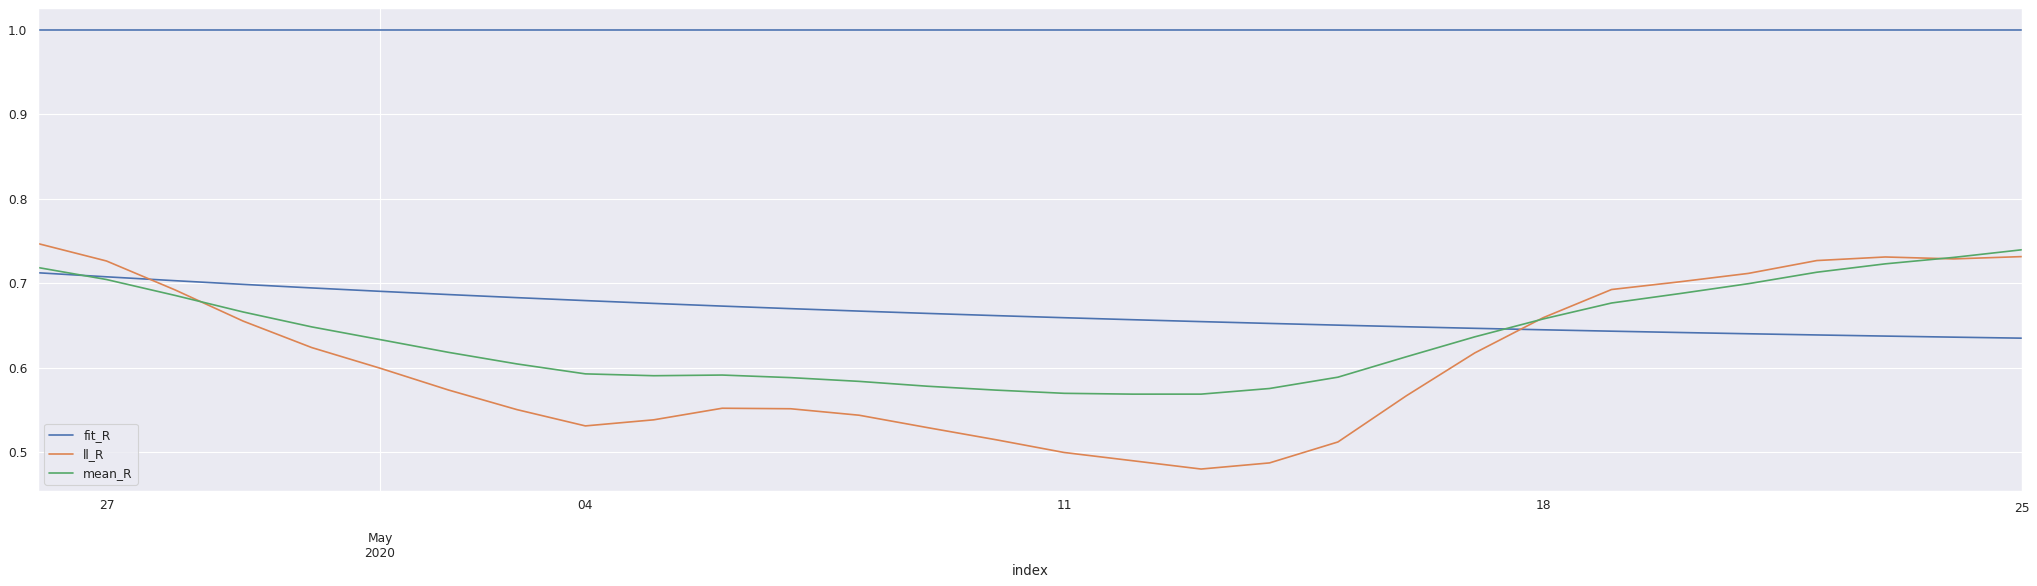

In [36]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_traunstein.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [37]:
df = covid19.get_rki_df(county='SK Regensburg')
cbr_sk_regensburg = covid19.CasesByRegion('SK Regensburg', df=df)
cbr_sk_regensburg.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-05-23,575,488,10,12,0,0
2020-05-24,616,488,10,41,0,0
2020-05-25,620,488,10,4,0,0
2020-05-26,620,488,10,0,0,0
2020-05-27,620,488,10,0,0,0


In [38]:
tage_inzidenz_sk_regensburg = cbr_sk_regensburg.df['new_confirmed'][-tage_inzidenz:].sum()
round(tage_inzidenz_sk_regensburg,1), round(tage_inzidenz_sk_regensburg / einwohner_sk_regensburg / tage_inzidenz * 100000, 1), round(tage_inzidenz_sk_regensburg / einwohner_sk_regensburg / tage_inzidenz * 100000 * 7, 1)

(100, 6.6, 45.9)

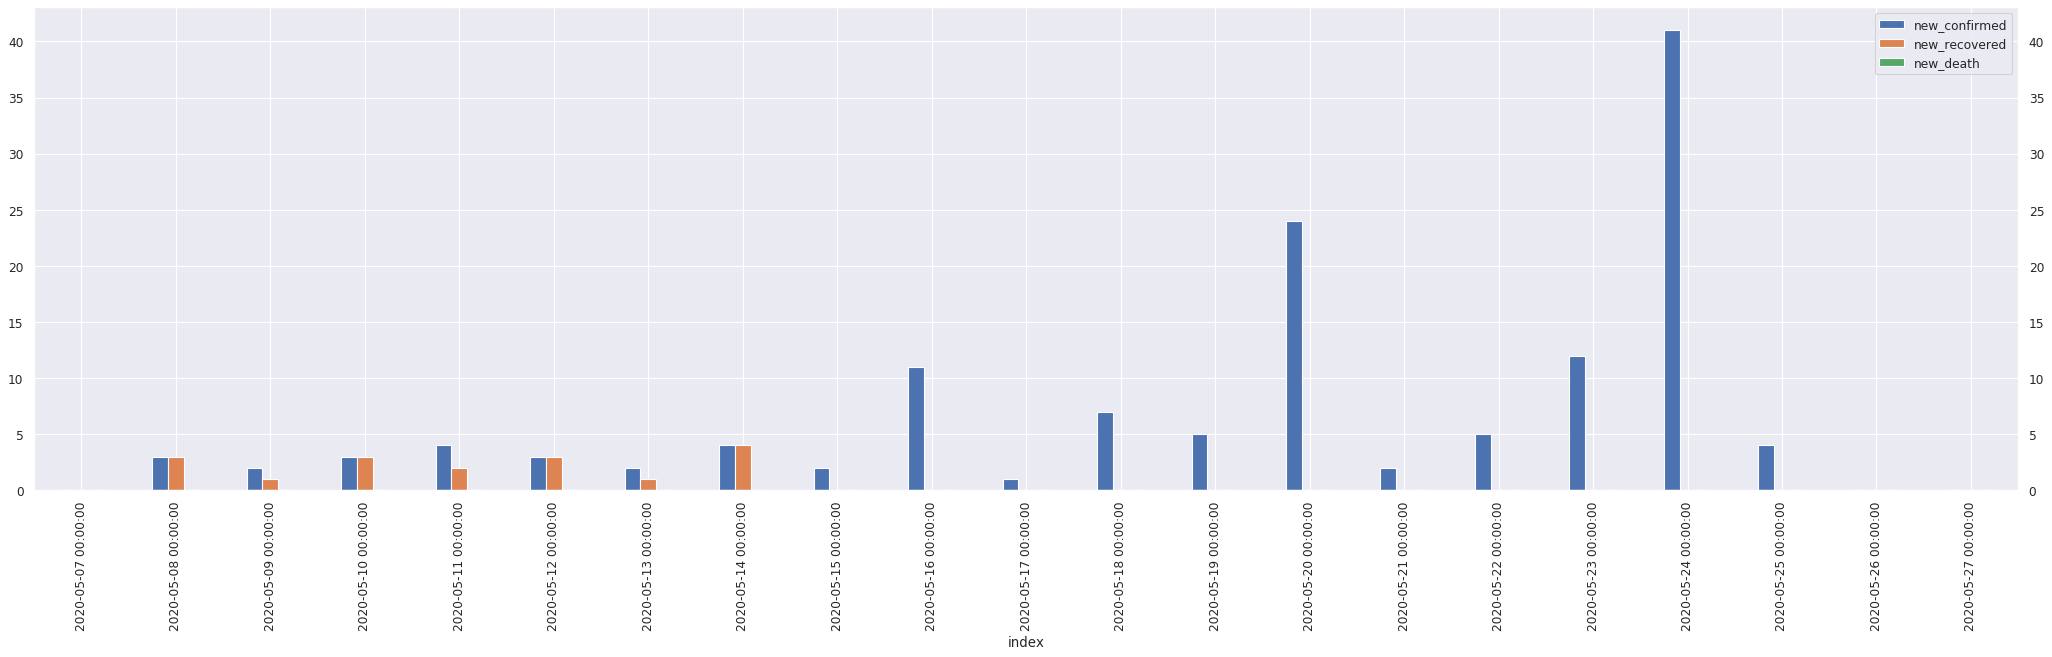

In [39]:
cbr_sk_regensburg.plot_daily_stats()

In [40]:
df = covid19.get_rki_df(county='LK Regensburg')
cbr_lk_regensburg = covid19.CasesByRegion('LK Regensburg', df=df)
cbr_lk_regensburg.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-05-23,463,436,15,0,0,0
2020-05-24,465,436,15,2,0,0
2020-05-25,467,436,15,2,0,0
2020-05-26,469,436,15,2,0,0
2020-05-27,469,436,15,0,0,0


In [41]:
tage_inzidenz_lk_regensburg = cbr_lk_regensburg.df['new_confirmed'][-tage_inzidenz:].sum()
tage_inzidenz_lk_regensburg, round(tage_inzidenz_lk_regensburg / einwohner_lk_regensburg / tage_inzidenz * 100000, 1), round(tage_inzidenz_lk_regensburg / einwohner_lk_regensburg / tage_inzidenz * 100000 * 7, 1)

(11, 0.6, 4.0)

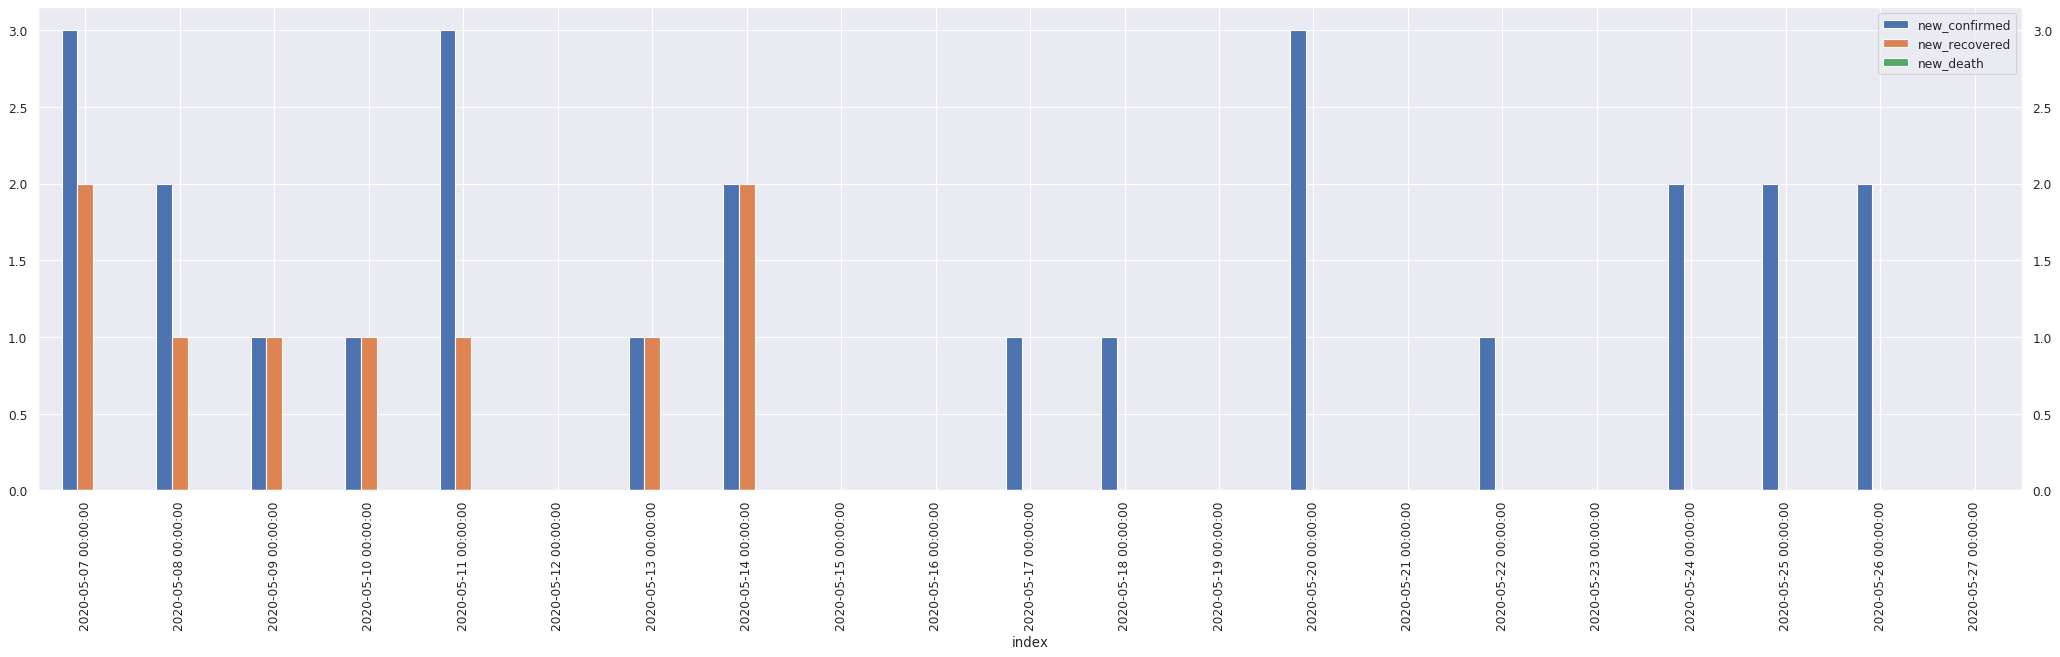

In [42]:
cbr_lk_regensburg.plot_daily_stats()

In [43]:
# --------------------------------------------------------------------------------------------------------------------------------



# --------------------------------------------------------------------------------------------------------------------------------

In [44]:
df = covid19.get_rki_df(time_anchor_column_name='Meldedatum')
cbr_germany2 = covid19.CasesByRegion('Germany', df=df)
cbr_germany2.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-05-23,177725,162650,8259,344,18,31
2020-05-24,177938,162654,8280,213,4,21
2020-05-25,178343,162676,8308,405,22,28
2020-05-26,178923,162692,8369,580,16,61
2020-05-27,179216,162696,8429,293,4,60


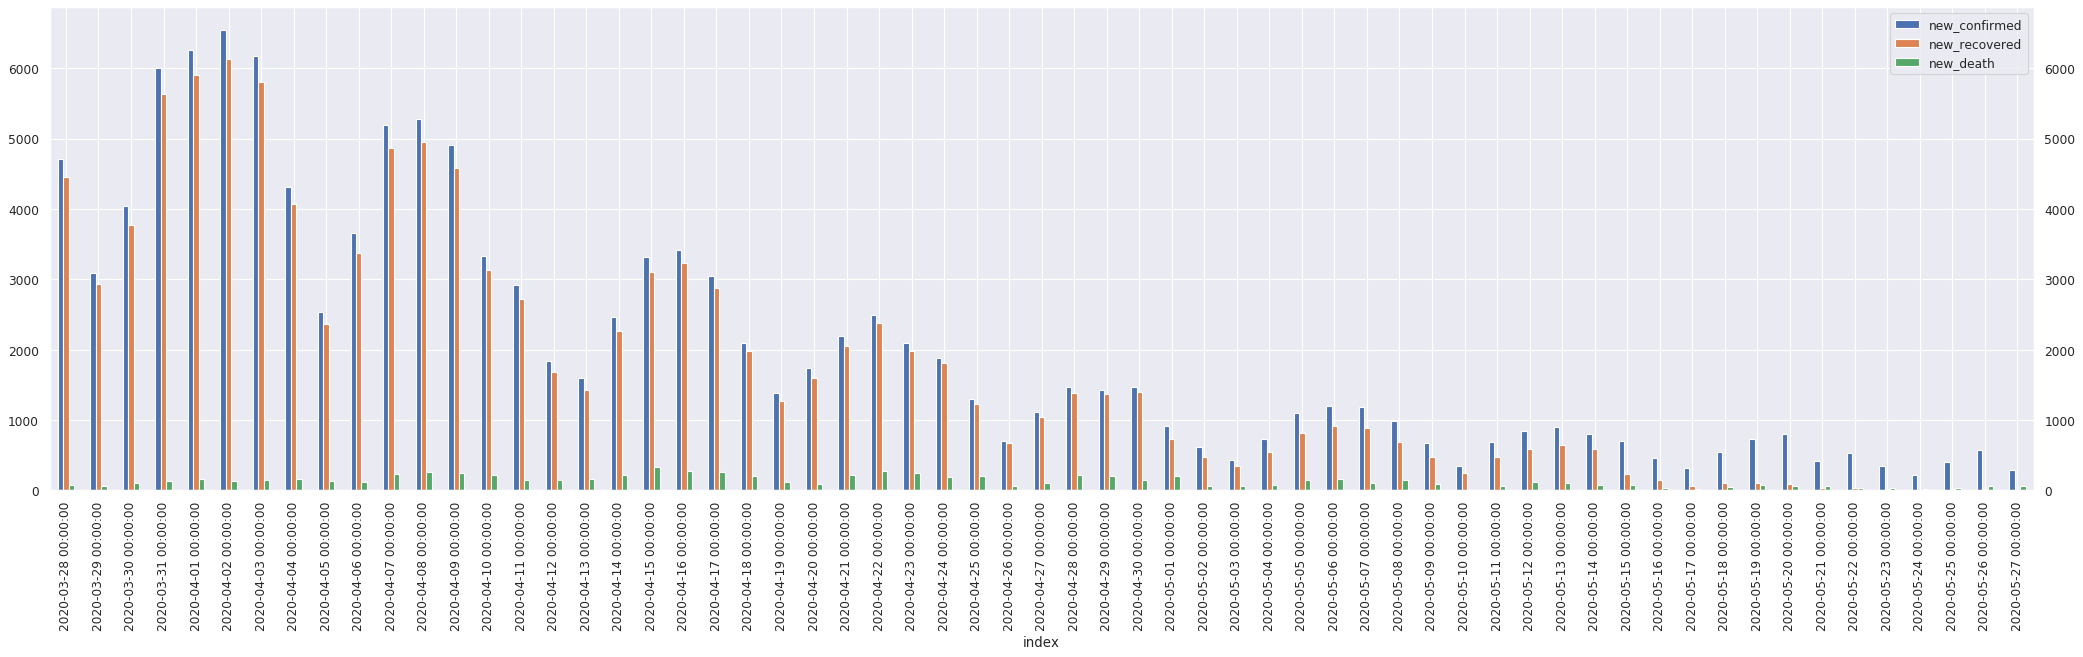

In [45]:
cbr_germany2.plot_daily_stats(days=60)

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None


sigmoid+asymmetric+linear: seor: 747.1091712076112; growth-rate: 0.003, date:2020-07-05 00:00:00, projected value: 484.83065971213006


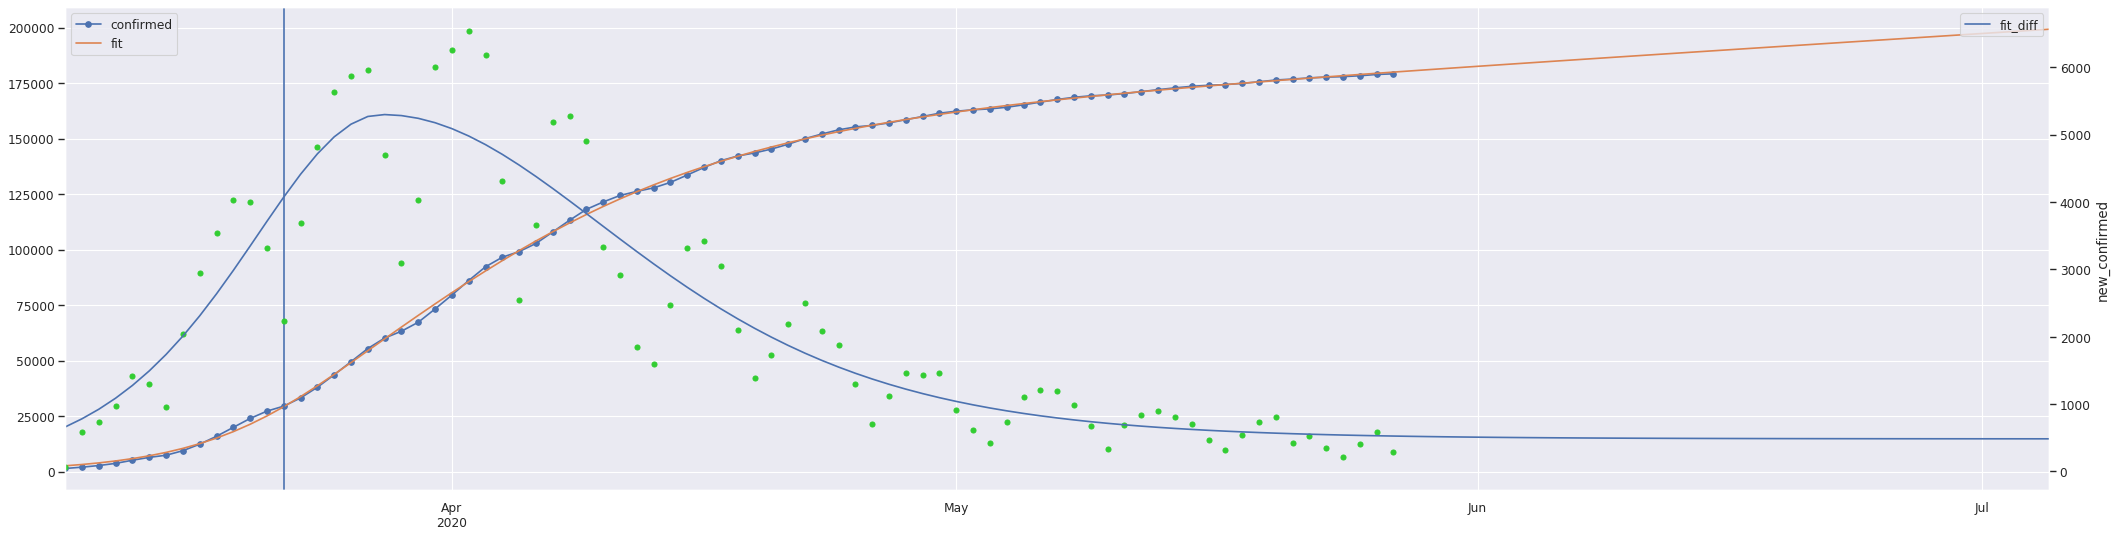

In [46]:
cbr_germany2.fit(first_date=pd.to_datetime('2020-03-09'))
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_germany2.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 22))

In [47]:
cbr_germany2.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,5299.211277


In [48]:
cbr_germany2.calculate_R_estimates()
cbr_germany2.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


,fit_R,gp_R,kf_R,ll_R,mean_R
index,,,,,
2020-05-25,0.907,0.778,0.755,0.744,0.809


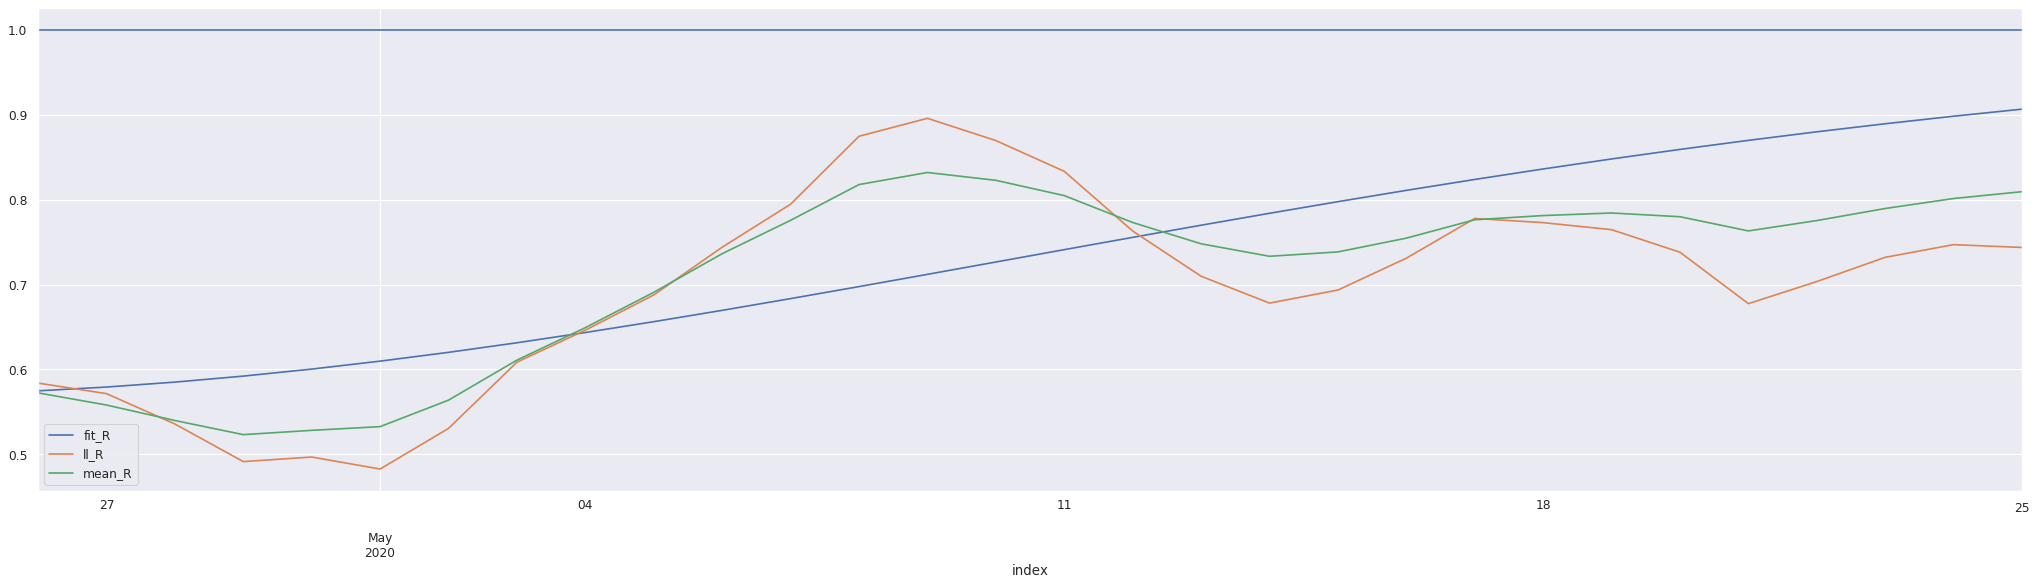

In [49]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_germany2.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [50]:
cbr_germany3 = covid19.CasesByRegion('Germany')
cbr_germany3.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-05-23,178190,159716,8259,471,652,31
2020-05-24,178568,160281,8280,378,565,21
2020-05-25,178864,161199,8308,296,918,28
2020-05-26,179274,161967,8369,410,768,61
2020-05-27,179930,162820,8429,656,853,60


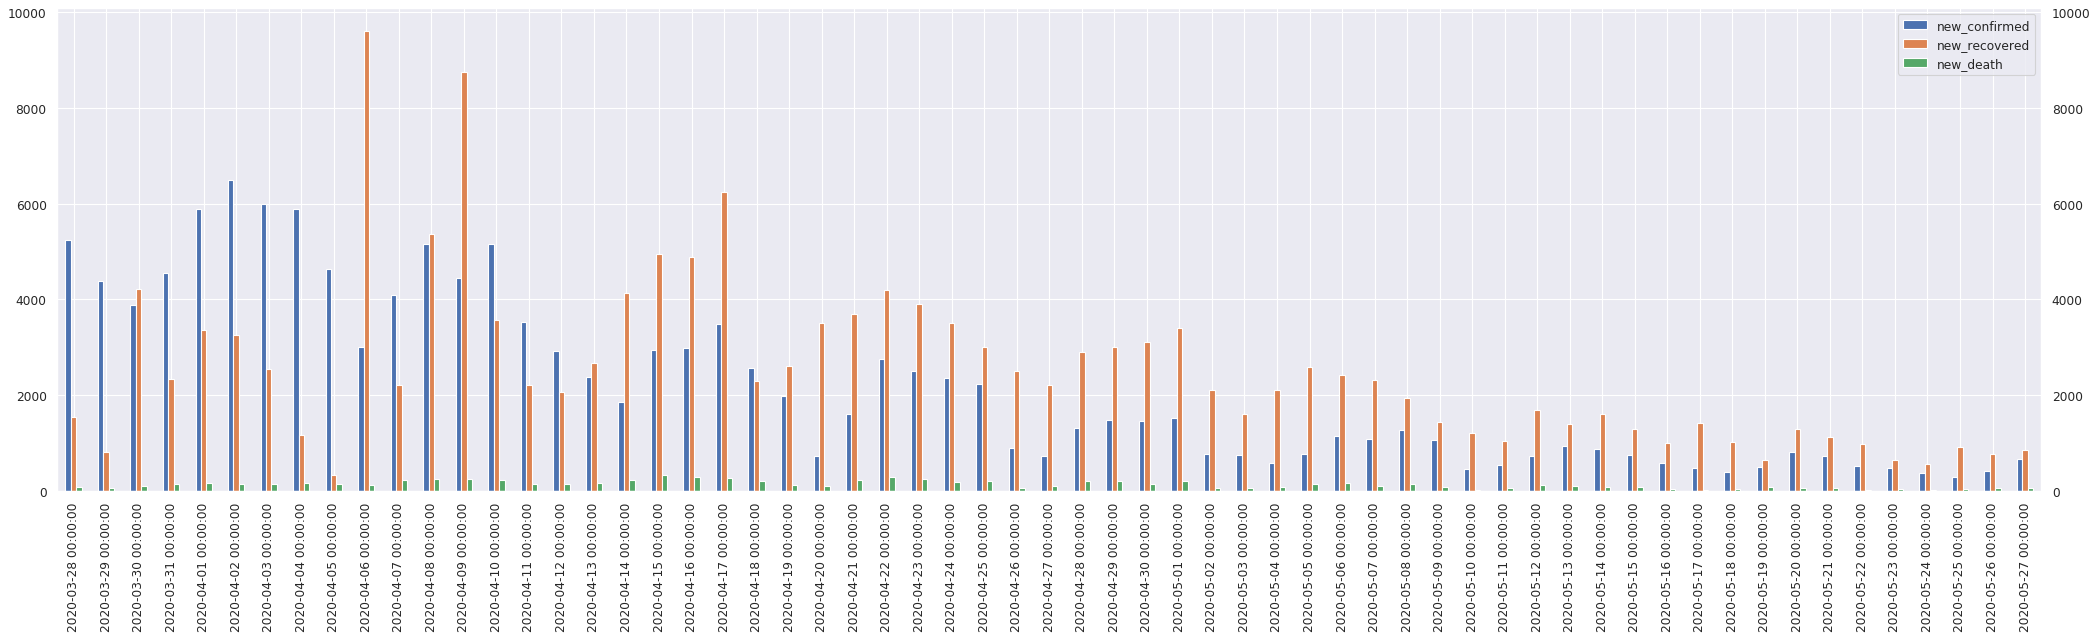

In [51]:
cbr_germany3.plot_daily_stats(days=60)

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None


sigmoid+asymmetric+linear: seor: 650.7557987216501; growth-rate: 0.003, date:2020-07-05 00:00:00, projected value: 513.8069967633313


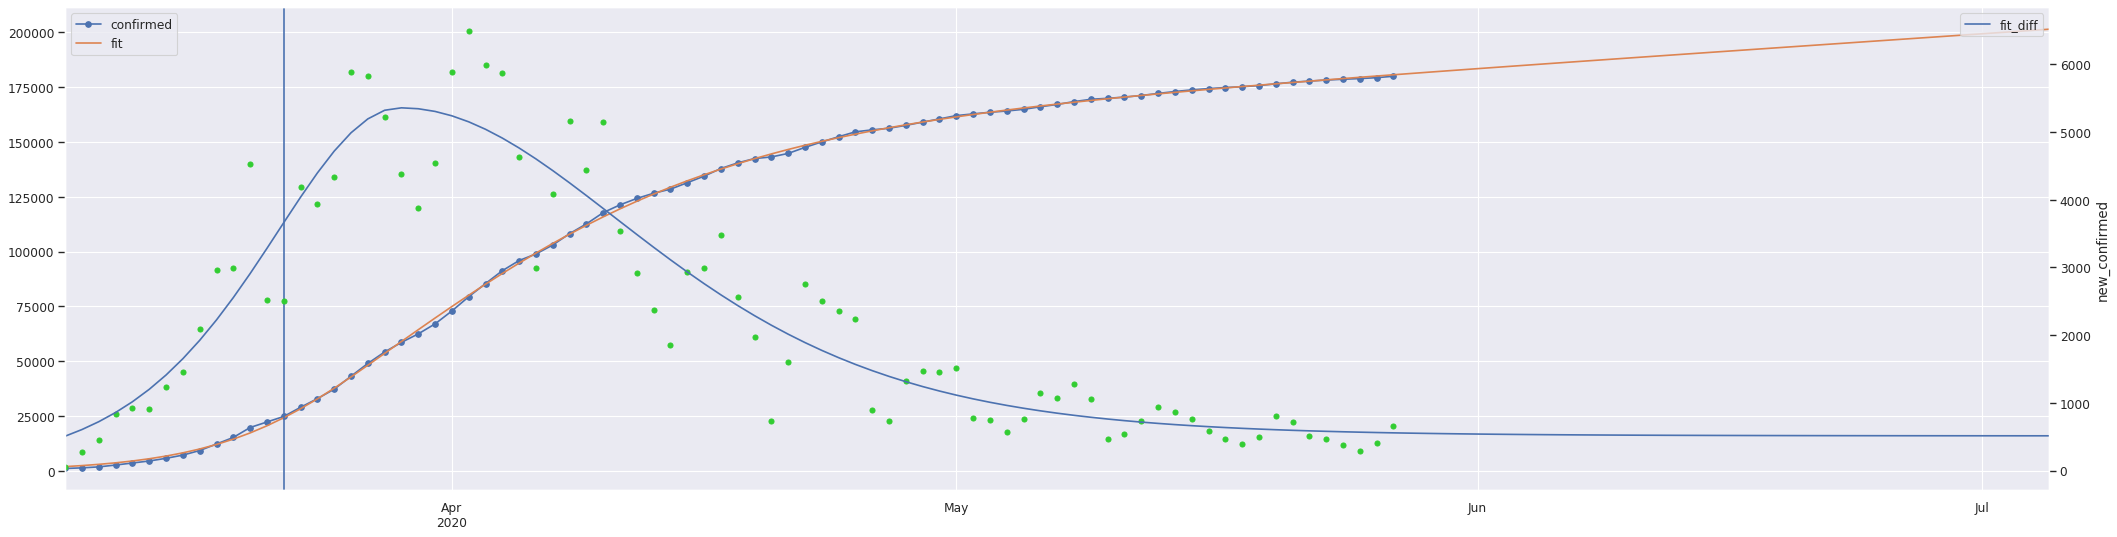

In [52]:
cbr_germany3.fit(first_date=pd.to_datetime('2020-03-09'))
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_germany3.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 22))

In [53]:
cbr_germany3.calculate_R_estimates()
cbr_germany3.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


,fit_R,gp_R,kf_R,ll_R,mean_R
2020-05-25,0.905,0.825,0.819,0.761,0.831


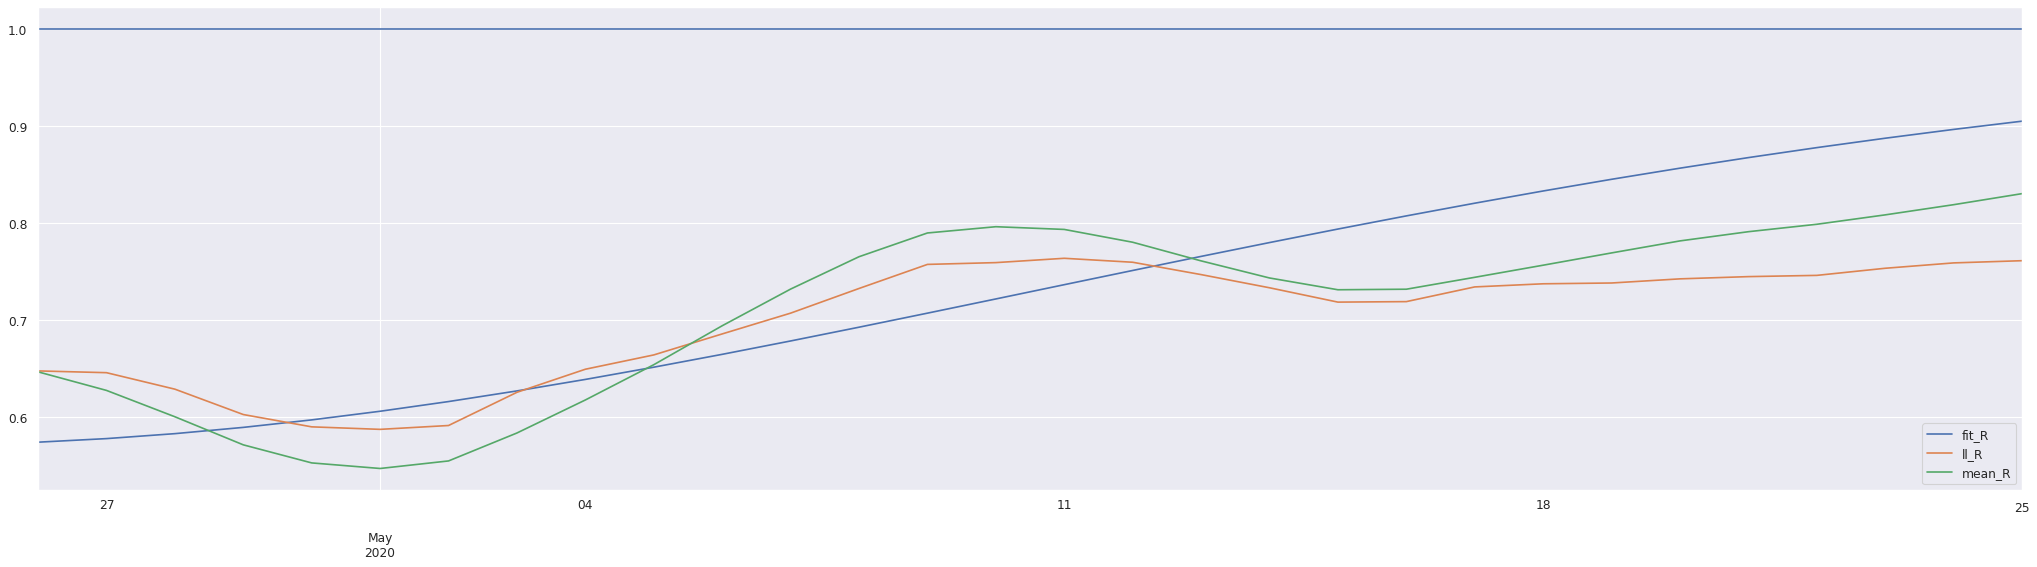

In [54]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_germany3.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [55]:
import requests

In [56]:
# https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Projekte_RKI/Nowcasting.html
# rki_nowcasting_data_url = 'https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Projekte_RKI/Nowcasting_Zahlen.xlsx'
rki_nowcasting_data_url = 'https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Projekte_RKI/Nowcasting_Zahlen.xlsx?__blob=publicationFile'

r = requests.get(rki_nowcasting_data_url, allow_redirects=True)  # to get content after redirection
# r.url, r.content
xd = pd.ExcelFile(r.content)
rki_nowcasting_df_ = xd.parse(xd.sheet_names[-1])
rki_nowcasting_df_.to_excel("rki_nowcasting_data.xlsx") 
rki_nowcasting_df_.tail()

,Datum des Erkrankungsbeginns,Punktschätzer der Anzahl Neuerkrankungen (ohne Glättung),Untere Grenze des 95%-Prädiktionsintervalls der Anzahl Neuerkrankungen (ohne Glättung),Obere Grenze des 95%-Prädiktionsintervalls der Anzahl Neuerkrankungen (ohne Glättung),Punktschätzer der Anzahl Neuerkrankungen,Untere Grenze des 95%-Prädiktionsintervalls der Anzahl Neuerkrankungen,Obere Grenze des 95%-Prädiktionsintervalls der Anzahl Neuerkrankungen,Punktschätzer der Reproduktionszahl R,Untere Grenze des 95%-Prädiktionsintervalls der Reproduktionszahl R,Obere Grenze des 95%-Prädiktionsintervalls der Reproduktionszahl R,Punktschätzer des 7-Tage-R Wertes,Untere Grenze des 95%-Prädiktionsintervalls des 7-Tage-R Wertes,Obere Grenze des 95%-Prädiktionsintervalls des 7-Tage-R Wertes
78,2020-05-19,453,382,524,502,434,567,0.83,0.77,0.91,0.90,0.85,0.94
79,2020-05-20,509,403,612,501,419,578,0.88,0.80,0.96,0.87,0.82,0.92
80,2020-05-21,323,234,416,470,380,556,0.87,0.79,0.97,0.79,0.74,0.84
81,2020-05-22,277,183,379,390,300,483,0.70,0.63,0.80,0.76,0.70,0.81
82,2020-05-23,245,139,389,338,239,449,0.68,0.57,0.79,NaN,NaN,NaN


In [57]:
rki_nowcasting_df = rki_nowcasting_df_[['Datum des Erkrankungsbeginns', 'Punktschätzer der Anzahl Neuerkrankungen (ohne Glättung)', 'Punktschätzer der Anzahl Neuerkrankungen']].copy()
rki_nowcasting_df.columns = ['index', 'new_confirmed', 'new_confirmed_']
rki_nowcasting_df['index'] = pd.to_datetime(rki_nowcasting_df['index'])
rki_nowcasting_df = rki_nowcasting_df.set_index('index')

last_date = rki_nowcasting_df.index[-1] + pd.DateOffset(days=1)
last_value = cbr_germany.df['confirmed'].loc[last_date]
# last_date, last_value

ldf = pd.DataFrame(index=rki_nowcasting_df.index)
ldf['confirmed'] = last_value - rki_nowcasting_df['new_confirmed'].values[::-1].cumsum()[::-1]
ldf.loc[last_date] = [last_value]
ldf['recovered'] = 0
ldf['death']     = 0
ldf['new_confirmed'] = covid19.discrete_diff(ldf['confirmed'])
ldf['new_recovered'] = covid19.discrete_diff(ldf['recovered'])
ldf['new_death']     = covid19.discrete_diff(ldf['death'])

rki_nowcasting_df = ldf.copy()

cbr_germany4 = covid19.CasesByRegion('Germany', df=rki_nowcasting_df)
cbr_germany4.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-05-20,176999,0,0,453.0,0.0,0.0
2020-05-21,177508,0,0,509.0,0.0,0.0
2020-05-22,177831,0,0,323.0,0.0,0.0
2020-05-23,178108,0,0,277.0,0.0,0.0
2020-05-24,178353,0,0,245.0,0.0,0.0


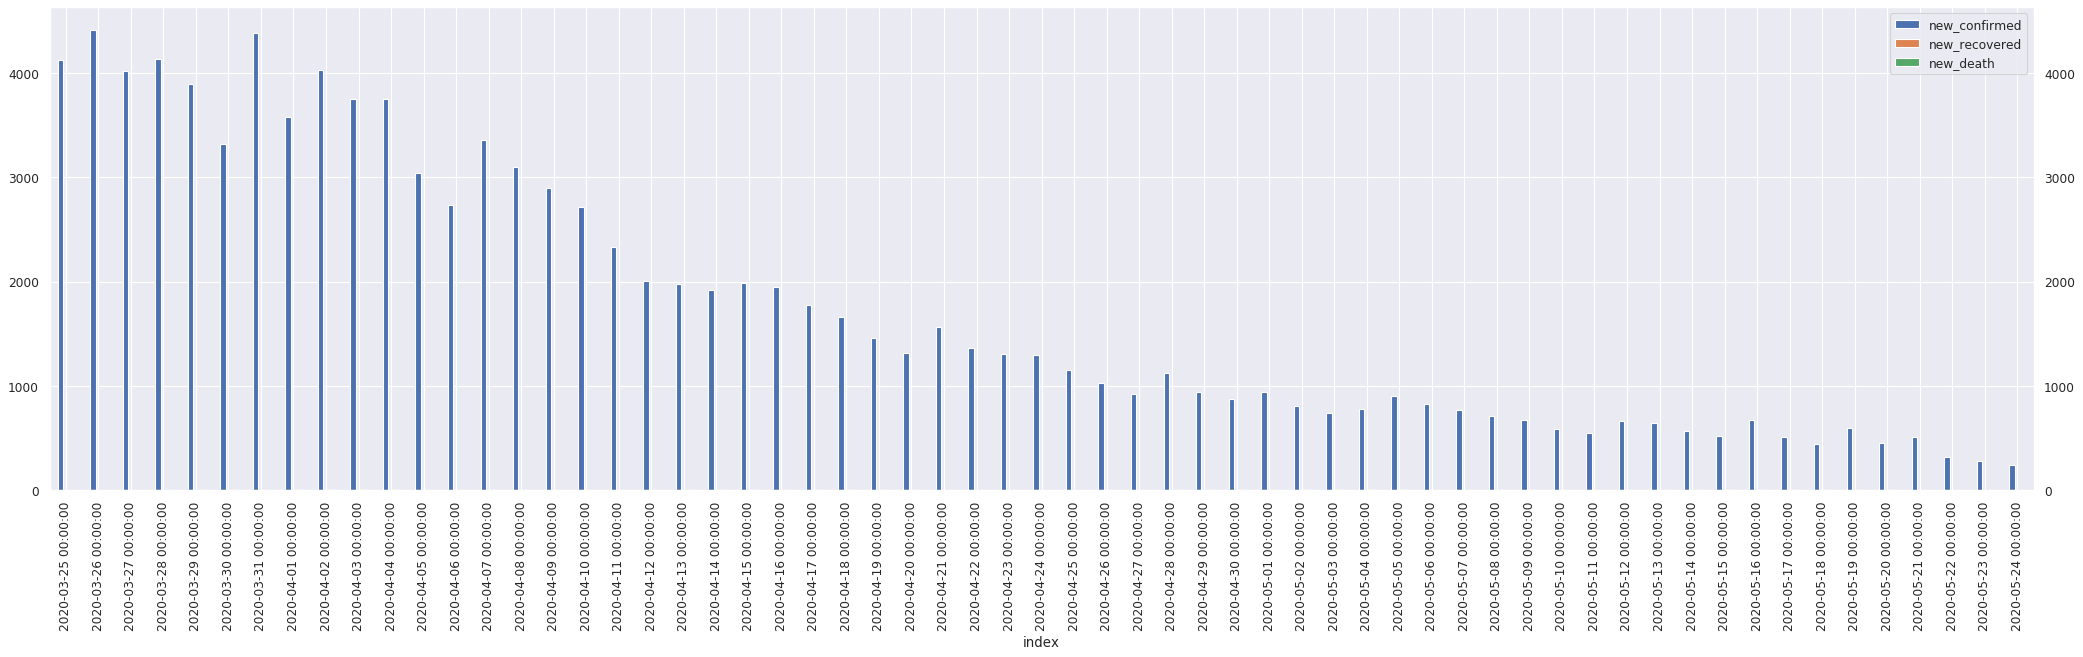

In [58]:
cbr_germany4.plot_daily_stats(days=60)

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None


sigmoid+asymmetric+linear: seor: 301.4421144009694; growth-rate: 0.003, date:2020-07-02 00:00:00, projected value: 319.8364296111261


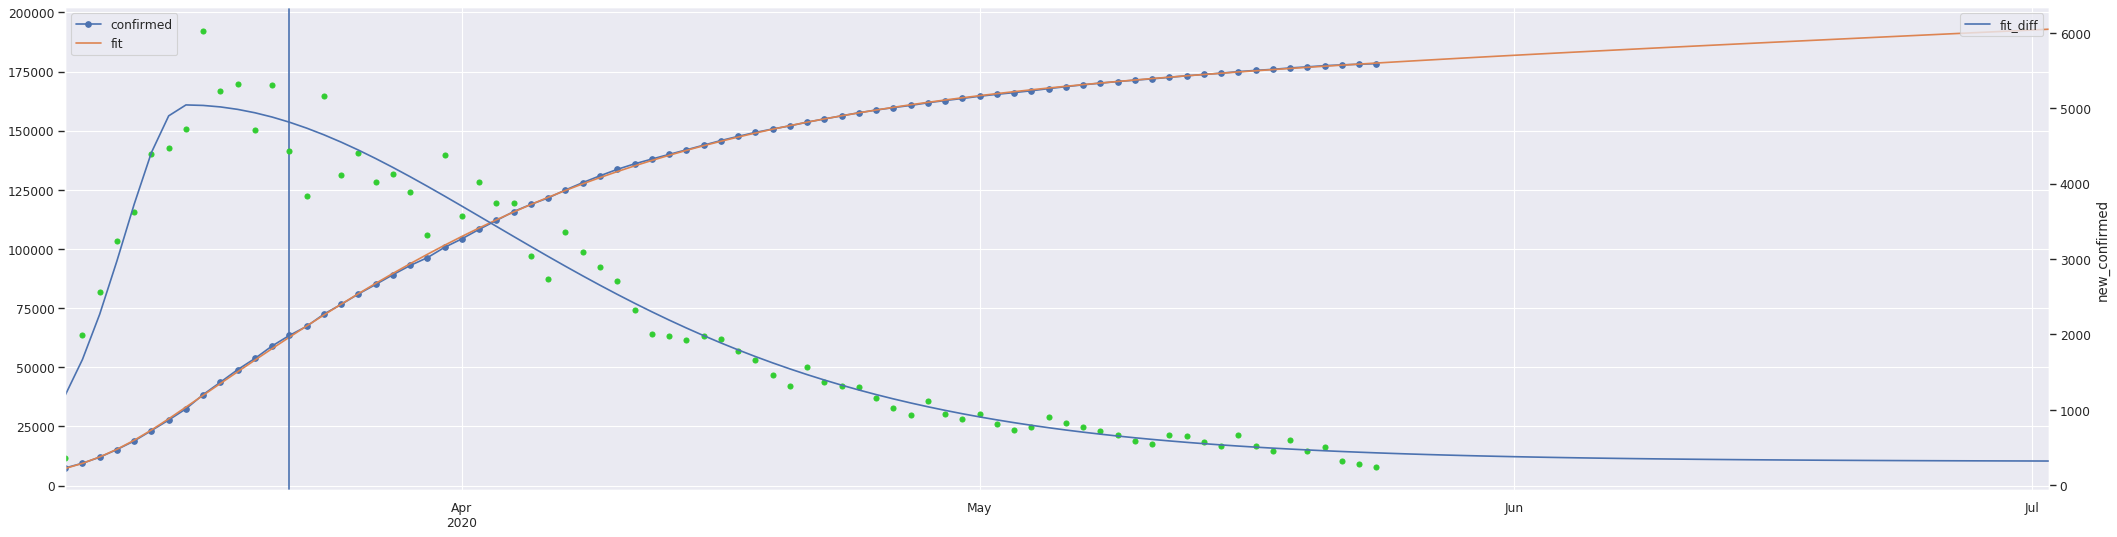

In [59]:
cbr_germany4.fit(first_date=pd.to_datetime('2020-03-09'))
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_germany4.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 22))

In [60]:
cbr_germany4.calculate_R_estimates()
cbr_germany4.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


,fit_R,gp_R,kf_R,ll_R,mean_R
index,,,,,
2020-05-22,0.822,0.717,0.662,0.635,0.725


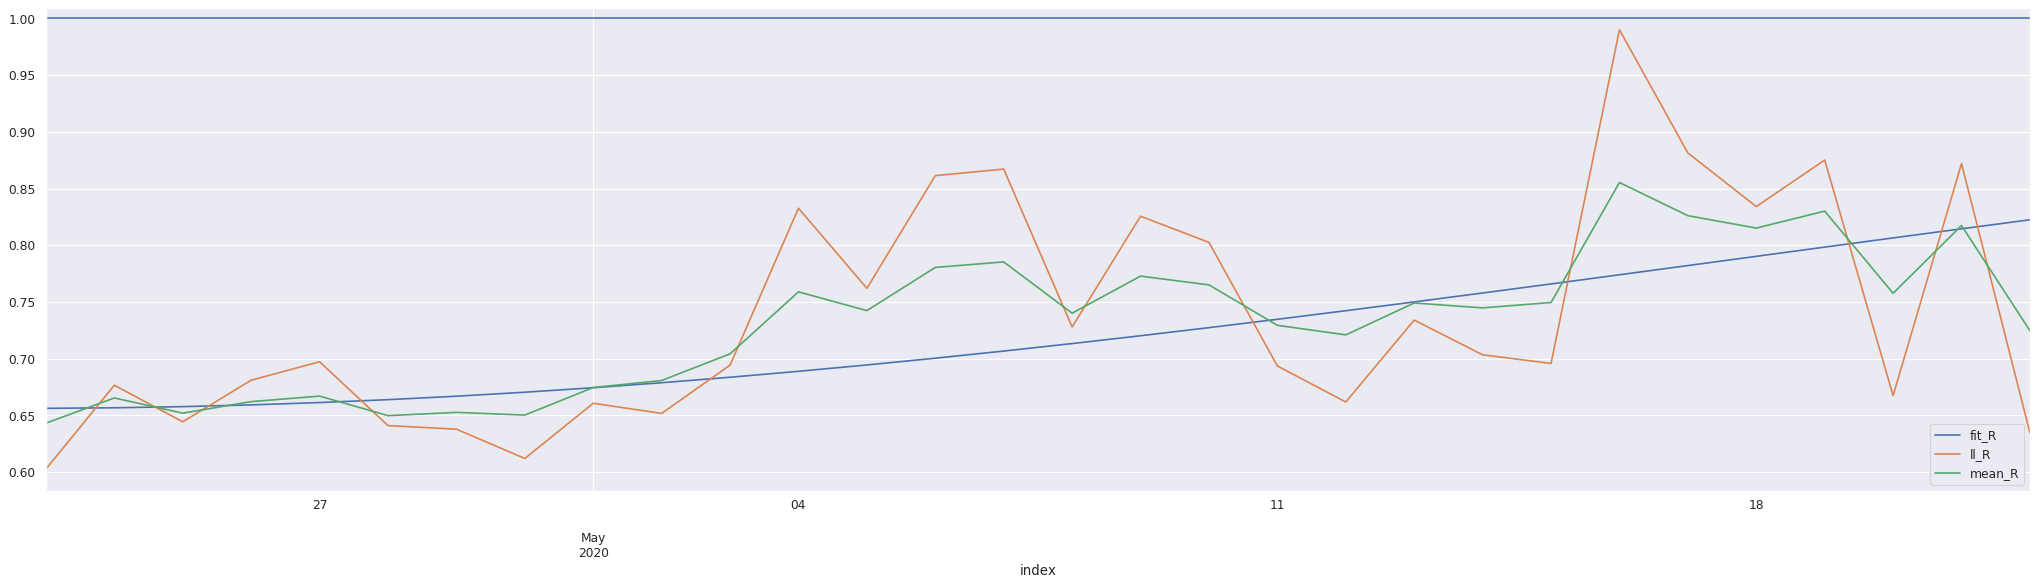

In [61]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_germany4.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [62]:
ldf = cbr_germany.df.loc[cbr_germany4.df.index, ['new_confirmed']]
ldf['new_confirmed_nc'] = cbr_germany4.df['new_confirmed']
ldf['delta'] = ldf['new_confirmed_nc'] - ldf['new_confirmed']
ldf = ldf.astype(np.int)
ldf.iloc[-30:]

,new_confirmed,new_confirmed_nc,delta
index,,,
2020-04-25,1171,1156,-15
2020-04-26,765,1030,265
2020-04-27,1184,925,-259
2020-04-28,1095,1121,26
2020-04-29,1080,943,-137
2020-04-30,1145,877,-268
2020-05-01,837,942,105
2020-05-02,667,807,140
2020-05-03,580,738,158
